# Polyhedral Optimization Evaluation

The Polybench tests were used for doing polyhedral optimization - essentially, trying to improve locality of memory in algebra kernels selected from a range of different fields.  Thus, they are an appropriate tool for studying/analyzing the behavior of PMEM, particularly with respect to its locality.

In late December 2019 I collected a series of data points for Polybench using Intel Optane DC Persistent Memory (Generation 1).  The system that I used deviates from the prior platform because the CPU was replaced.  Thus, I cannot directly compare this data.  This is the same memory, however, so I can still draw reasonable conclusions from this data and make normalized data comparisons (albeit carefully).

```
[tony@localhost polybench-3.2]$ lscpu
Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   46 bits physical, 48 bits virtual
CPU(s):                          80
On-line CPU(s) list:             0-79
Thread(s) per core:              2
Core(s) per socket:              20
Socket(s):                       2
NUMA node(s):                    2
Vendor ID:                       GenuineIntel
CPU family:                      6
Model:                           85
Model name:                      Genuine Intel(R) CPU 0000%@
Stepping:                        6
CPU MHz:                         1000.024
CPU max MHz:                     3900.0000
CPU min MHz:                     1000.0000
BogoMIPS:                        5000.00
Virtualization:                  VT-x
L1d cache:                       1.3 MiB
L1i cache:                       1.3 MiB
L2 cache:                        40 MiB
L3 cache:                        55 MiB
NUMA node0 CPU(s):               0-19,40-59
NUMA node1 CPU(s):               20-39,60-79
Vulnerability L1tf:              Not affected
Vulnerability Meltdown:          Not affected
Vulnerability Spec store bypass: Mitigation; Speculative Store Bypass disabled via prctl and seccomp
Vulnerability Spectre v1:        Mitigation; __user pointer sanitization
Vulnerability Spectre v2:        Mitigation; Enhanced IBRS, IBPB conditional, RSB filling
Flags:                           fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse
                                  sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art arch_perfmon pebs bts rep_good nopl
                                 xtopology nonstop_tsc cpuid aperfmperf pni pclmulqdq dtes64 monitor ds_cpl vmx smx est tm2 ssse3 sdbg
                                  fma cx16 xtpr pdcm pcid dca sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c
                                 rdrand lahf_lm abm 3dnowprefetch cpuid_fault epb cat_l3 cdp_l3 invpcid_single ssbd mba ibrs ibpb stib
                                 p ibrs_enhanced tpr_shadow vnmi flexpriority ept vpid ept_ad fsgsbase tsc_adjust bmi1 hle avx2 smep b
                                 mi2 erms invpcid rtm cqm mpx rdt_a avx512f avx512dq rdseed adx smap clflushopt clwb intel_pt avx512cd
                                  avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves cqm_llc cqm_occup_llc cqm_mbm_total cqm_mbm_local d
                                 therm ida arat pln pts hwp hwp_act_window hwp_epp hwp_pkg_req pku ospke avx512_vnni flush_l1d arch_ca
                                 pabilities
[tony@localhost polybench-3.2]$ uname -a
Linux intelsdp1044 5.0.0+ #4 SMP Wed Sep 4 15:41:42 EDT 2019 x86_64 x86_64 x86_64 GNU/Linux
```

There are four fewer cores, but the L1, L2, and L3 caches are **substantially** larger.  This will have significant impact on the overall sytem performance.

I have also switched compilers because the **gcc** does not appear to directly support the polyhedral optimizations.  **clang** does (though I had to build it from sources to do so; the Fedora 31 distributed version doesn't seem to have the support).

```
[tony@localhost polybench-3.2]$ clang --version
clang version 10.0.0 (http://llvm.org/git/clang.git 65acf43270ea2894dffa0d0b292b92402f80c8cb) (http://llvm.org/git/llvm.git 2c4ca6832fa6b306ee6a7010bfb80a3f2596f824)
Target: x86_64-unknown-linux-gnu
Thread model: posix
InstalledDir: /home/tony/projects/polly/llvm_build/bin
```



In [1]:
#!/usr/bin/python3

import os
import sys
import matplotlib.pyplot as plt
import matplotlib.dates as matdates
import tikzplotlib
import numpy as np
import pandas as pd
from collections import OrderedDict
import locale
import statistics
from scipy.stats.mstats import gmean
from cycler import cycler

At this point, I have one run for each of the tests.  I have previously scanned similar log files, so I will need to adapt that code to understand the additional data present here.

Essentially, each test is now run twice: once **without** polyhedral optimization and once **with** polyhedral optimization.  In some cases, it makes things **much** faster, in others it makes tings **much slower**.  The questions to answer then are:

* Is the faster/slower comparable between DRAM, PMEM, and iPMEM?
* Is the faster/slower comparable between page sizes?
* If so, _why_ is this the case?  How does this map back?

More subtle questions that I may not be able to answer but should consider:

* Is the difference in performance here, with **much** larger caches, an important factor?
* Of the factors to consider: page size, read/write locality, and striping, what is their impact and which is most important.

Let's see what the data tells us.


In [2]:
# This code has not been modified from prior version(s) - December 29, 2019
class PerfDataTypes:
    """
             11,266.70 msec task-clock                #    1.000 CPUs utilized
                     4      context-switches          #    0.355 M/sec
                     0      cpu-migrations            #    0.000 K/sec
                22,030      page-faults               # 1955.441 M/sec
        41,292,991,932      cycles                    # 3665275.336 GHz                   (30.75%)
        57,539,842,386      instructions              #    1.39  insn per cycle           (38.44%)
         6,774,876,761      branches                  # 601356005.770 M/sec               (38.45%)
             4,832,518      branch-misses             #    0.07% of all branches          (38.46%)
        13,526,507,060      L1-dcache-loads           # 1200648594.000 M/sec              (38.47%)
         9,012,615,601      L1-dcache-load-misses     #   66.63% of all L1-dcache hits    (38.47%)
           849,715,461      LLC-loads                 # 75422994.941 M/sec                (30.78%)
             4,911,229      LLC-load-misses           #    0.58% of all LL-cache hits     (30.78%)
       <not supported>      L1-icache-loads
             3,776,205      L1-icache-load-misses                                         (30.78%)
        13,547,867,184      dTLB-loads                # 1202544575.182 M/sec              (30.78%)
         2,066,428,912      dTLB-load-misses          #   15.25% of all dTLB cache hits   (30.77%)
                   338      iTLB-loads                #   30.002 M/sec                    (30.76%)
                 5,183      iTLB-load-misses          # 1533.43% of all iTLB cache hits   (30.75%)
       <not supported>      L1-dcache-prefetches
       <not supported>      L1-dcache-prefetch-misses
    """
    
    @staticmethod 
    def convert_float(value):
        """Convert a string float value"""
        locale.setlocale(locale.LC_NUMERIC, '') #default locale
        return locale.atof(value)
    
    @staticmethod
    def convert_int(value):
        """Convert a string int value"""
        locale.setlocale(locale.LC_NUMERIC, '') # default
        return locale.atoi(value)

    
    @staticmethod
    def task_clock(line):
        """             11,266.70 msec task-clock                #    1.000 CPUs utilized"""
        if line is None: line = "             11,266.70 msec task-clock                #    1.000 CPUs utilized" # Testing
        fields = line.strip().split('#')
        field1 = fields[0].split() # [11,266.70, 'msec', 'task-clock']
        field2 = fields[1].split() # [1.000, 'CPUs' 'utilized']
        return {field1[-1] : (PerfDataTypes.convert_float(field1[0]), 
                              field1[1], 
                              PerfDataTypes.convert_float(field2[0]),
                              " ".join(field2[1:]))}

    @staticmethod
    def context_switches(line):
        """                     4      context-switches          #    0.355 M/sec"""
        if line is None: line = "                     4      context-switches          #    0.355 M/sec"
        fields = line.strip().split('#')
        field1 = fields[0].split() # [4, 'context-switches']
        field2 = fields[1].split() # ['0.355', 'M/sec']
        return {field1[-1] : (PerfDataTypes.convert_int(field1[0]),
                              PerfDataTypes.convert_float(field2[0]),
                              field2[1])}

    @staticmethod
    def cpu_migrations(line):
        """0      cpu-migrations            #    0.000 K/sec"""
        if line is None: line = "0      cpu-migrations            #    0.000 K/sec"
        fields = line.strip().split('#')
        field1 = fields[0].split() # ['0', 'cpu-migrations']
        field2 = fields[1].split() # ['0.000', 'K/sec']
        return {field1[-1] : (PerfDataTypes.convert_int(field1[0]),
                              PerfDataTypes.convert_float(field2[0]),
                              field2[1])}

    @staticmethod
    def page_faults(line):
        """                22,030      page-faults               # 1955.441 M/sec    """
        if line is None:  line = "                22,030      page-faults               # 1955.441 M/sec    "
        fields = line.strip().split('#')
        field1 = fields[0].split() # ['22,030', 'page-faults']
        field2 = fields[1].split() # ['1955.441', 'M/sec']
        return {field1[-1] : (PerfDataTypes.convert_int(field1[0]),
                              PerfDataTypes.convert_float(field2[0]),
                              field2[1])}

    @staticmethod
    def cycles(line):
        """        41,292,991,932      cycles                    # 3665275.336 GHz                   (30.75%)"""
        if line is None: line = "        41,292,991,932      cycles                    # 3665275.336 GHz                   (30.75%)"
        fields = line.strip().split('#')
        field1 = fields[0].split() # [41,292,991,932, 'cycles']
        field2 = fields[1].split() # ['3.665275', 'GHz', '(30.75%)']
        return {field1[-1] : (PerfDataTypes.convert_int(field1[0]),
                              PerfDataTypes.convert_float(field2[0]),
                              field2[1],
                              PerfDataTypes.convert_float(field2[-1][field2[-1].index('(')+1:field2[-1].index('%')])) }

    @staticmethod
    def instructions(line):
        """        57,539,842,386      instructions              #    1.39  insn per cycle           (38.44%)"""
        if line is None: line = "        57,539,842,386      instructions              #    1.39  insn per cycle           (38.44%)"
        fields = line.strip().split('#')
        field1 = fields[0].split() # [57,539,842,386, 'instructions']
        field2 = fields[1].split() # [1.39, 'insn', 'per', 'cycle', '(38.44%)']
        return {field1[-1] : (PerfDataTypes.convert_int(field1[0]),
                              PerfDataTypes.convert_float(field2[0]),
                              " ".join(field2[1:3]),
                              PerfDataTypes.convert_float(field2[-1][field2[-1].index('(')+1:field2[-1].index('%')])) }

    @staticmethod
    def branches(line):
        """         6,774,876,761      branches                  # 601356005.770 M/sec               (38.45%)"""
        if line is None: line = "         6,774,876,761      branches                  # 601356005.770 M/sec               (38.45%)"
        fields = line.strip().split('#')
        field1 = fields[0].split() # [6,774,876,761, 'branches']
        field2 = fields[1].split() # ['601356005.770', 'M/sec', '(38.45%)']
        return {field1[-1] : (PerfDataTypes.convert_int(field1[0]),
                              PerfDataTypes.convert_float(field2[0]),
                              field2[1],
                              PerfDataTypes.convert_float(field2[-1][field2[-1].index('(')+1:field2[-1].index('%')])) }

    @staticmethod
    def branch_misses(line):
        """             4,832,518      branch-misses             #    0.07% of all branches          (38.46%)"""
        if line is None: line = "             4,832,518      branch-misses             #    0.07% of all branches          (38.46%)"
        fields = line.strip().split('#')
        field1 = fields[0].split() # [4,832,518, 'branch-misses']
        field2 = fields[1].split() # [0.07%, 'of', 'all', 'branches', '(38.46%)']
        return {field1[-1] : (PerfDataTypes.convert_int(field1[0]),
                              " ".join(field2[1:4]),
                              PerfDataTypes.convert_float(field2[-1][field2[-1].index('(')+1:field2[-1].index('%')])) }

    @staticmethod
    def l1_dcache_loads(line):
        """        13,526,507,060      L1-dcache-loads           # 1200648594.000 M/sec              (38.47%)        """
        if line is None: line = "        13,526,507,060      L1-dcache-loads           # 1200648594.000 M/sec              (38.47%)        "
        fields = line.strip().split('#')
        field1 = fields[0].split() # [13,526,507,060, 'L1-dcache-loads']
        field2 = fields[1].split() # ['1200648594.000', 'M/sec', '(38.47%)']
        return {field1[-1] : (PerfDataTypes.convert_int(field1[0]),
                              PerfDataTypes.convert_float(field2[0]),
                              field2[1],
                              PerfDataTypes.convert_float(field2[-1][field2[-1].index('(')+1:field2[-1].index('%')])) }

    @staticmethod
    def l1_dcache_load_misses(line):
        """         9,012,615,601      L1-dcache-load-misses     #   66.63% of all L1-dcache hits    (38.47%)        """
        if line is None: line =  "         9,012,615,601      L1-dcache-load-misses     #   66.63% of all L1-dcache hits    (38.47%)        "
        fields = line.strip().split('#')
        field1 = fields[0].split() # [9,012,615,601, 'L1-dcache-load-misses']
        field2 = fields[1].split() # [66.63%, 'of', 'all', 'L1-dcache', 'hits', (38.46%)']
        return {field1[-1] : (PerfDataTypes.convert_int(field1[0]),
                              " ".join(field2[1:5]),
                              PerfDataTypes.convert_float(field2[-1][field2[-1].index('(')+1:field2[-1].index('%')])) }

    @staticmethod
    def llc_loads(line):
        """           849,715,461      LLC-loads                 # 75422994.941 M/sec                (30.78%)"""
        if line is None: line = "           849,715,461      LLC-loads                 # 75422994.941 M/sec                (30.78%)"
        fields = line.strip().split('#')
        field1 = fields[0].split() # [849,715,461, 'LC-loads']
        field2 = fields[1].split() # ['75422994.941', 'M/sec', '(30.78%)']
        return {field1[-1] : (PerfDataTypes.convert_int(field1[0]),
                              PerfDataTypes.convert_float(field2[0]),
                              field2[1],
                              PerfDataTypes.convert_float(field2[-1][field2[-1].index('(')+1:field2[-1].index('%')])) }

    @staticmethod
    def llc_load_misses(line):
        """             4,911,229      LLC-load-misses           #    0.58% of all LL-cache hits     (30.78%)"""
        if line is None: line = "             4,911,229      LLC-load-misses           #    0.58% of all LL-cache hits     (30.78%)"
        fields = line.strip().split('#')
        field1 = fields[0].split() # [4,911,229, 'LLC-load-misses']
        field2 = fields[1].split() # [0.58%, 'of', 'all', 'LL-cache', 'hits', (30.78%)']
        return {field1[-1] : (PerfDataTypes.convert_int(field1[0]),
                              " ".join(field2[1:5]),
                              PerfDataTypes.convert_float(field2[-1][field2[-1].index('(')+1:field2[-1].index('%')])) }

    @staticmethod
    def l1_icache_loads(line):
        """       <not supported>      L1-icache-loads"""
        if line is None: line = "       <not supported>      L1-icache-loads"
        if 'not supported' in line: return None
        print(line)
        raise NotImplementedError

    @staticmethod
    def l1_icache_load_misses(line):
        """             3,776,205      L1-icache-load-misses                                         (30.78%)"""
        if line is None: line = "             3,776,205      L1-icache-load-misses                                         (30.78%)"
        fields = line.strip().split() # ['3,776,205', 'L1-icache-load-misses', '(30.78%)']
        return {fields[1] : (PerfDataTypes.convert_int(fields[0]), 
                             PerfDataTypes.convert_float(fields[-1][fields[-1].index('(')+1:fields[-1].index('%')]))}

    @staticmethod
    def dtlb_loads(line):
        """        13,547,867,184      dTLB-loads                # 1202544575.182 M/sec              (30.78%)"""
        if line is None: line = "        13,547,867,184      dTLB-loads                # 1202544575.182 M/sec              (30.78%)"
        fields = line.strip().split('#')
        field1 = fields[0].split() # [13,547,867,184, 'dTLB-loads']
        field2 = fields[1].split() # ['601356005.770', 'M/sec', '(38.45%)']
        return {field1[-1] : (PerfDataTypes.convert_int(field1[0]),
                              PerfDataTypes.convert_float(field2[0]),
                              field2[1],
                              PerfDataTypes.convert_float(field2[-1][field2[-1].index('(')+1:field2[-1].index('%')])) }

    @staticmethod
    def dtlb_load_misses(line):
        """         2,066,428,912      dTLB-load-misses          #   15.25% of all dTLB cache hits   (30.77%)"""
        if line is None: line = "         2,066,428,912      dTLB-load-misses          #   15.25% of all dTLB cache hits   (30.77%)"
        if '<not counted>' in line:
            # set to zero
            return {'dTLB-load-misses' : (0, 0, 'of all dTLB cache hits <not counted>')}
        fields = line.strip().split('#')
        field1 = fields[0].split() # [2,066,428,912, 'dTLB-load-misses']
        field2 = fields[1].split() # ['15.25%', 'of', 'all', 'dTLB', 'cache', 'hits', '(30.77%)']
        return {field1[-1] : (PerfDataTypes.convert_int(field1[0]),
                              PerfDataTypes.convert_float(field2[0][:field2[0].index('%')]),
                              " ".join(field2[1:6]),
                              PerfDataTypes.convert_float(field2[-1][field2[-1].index('(')+1:field2[-1].index('%')])) }

    @staticmethod
    def itlb_loads(line):
        """                   338      iTLB-loads                #   30.002 M/sec                    (30.76%)"""
        if line is None: line = "                   338      iTLB-loads                #   30.002 M/sec                    (30.76%)"
        if '<not counted>' in line:
            # set to zero
            return {'iTLB-loads' : (0, 0, '0.00 M/sec <not counted>')}
        fields = line.strip().split('#')
        field1 = fields[0].split() # [338, 'iTLB-loads']
        field2 = fields[1].split() # ['30.002', 'M/sec', '(30.76%)']
        return {field1[-1] : (PerfDataTypes.convert_int(field1[0]),
                              PerfDataTypes.convert_float(field2[0]),
                              field2[1],
                              PerfDataTypes.convert_float(field2[-1][field2[-1].index('(')+1:field2[-1].index('%')])) }

    @staticmethod
    def itlb_load_misses(line):
        """                 5,183      iTLB-load-misses          # 1533.43% of all iTLB cache hits   (30.75%)"""
        if line is None: line = "                 5,183      iTLB-load-misses          # 1533.43% of all iTLB cache hits   (30.75%)"
        if '<not counted>' in line:
            # set to zero
            return {'iTLB-load-misses' : (0, '0% of all iTLB cache hits <not counted>', 0.0)}
        fields = line.strip().split('#')
        field1 = fields[0].split() # [5,183, 'iTLB-load-misses']
        field2 = fields[1].split() # ['1533.43%', 'of', 'all', 'iTLB', 'cache', 'hits', '(30.75%)']
        return {field1[-1] : (PerfDataTypes.convert_int(field1[0]),
                              PerfDataTypes.convert_float(field2[0][:field2[0].index('%')]),
                              " ".join(field2[1:6]),
                              PerfDataTypes.convert_float(field2[-1][field2[-1].index('(')+1:field2[-1].index('%')])) }

    @staticmethod
    def l1_dcache_prefetches(line):
        """       <not supported>      L1-dcache-prefetches"""
        if line is None: line = "       <not supported>      L1-dcache-prefetches"
        if 'not supported' in line: return None
        print(line)
        raise NotImplementedError

    @staticmethod
    def l1_dcache_prefetch_misses(line):
        """       <not supported>      L1-dcache-prefetch-misses"""
        if line is None: line = "       <not supported>      L1-dcache-prefetch-misses"
        if 'not supported' in line: return None
        print(line)
        raise NotImplementedError

    @staticmethod
    def test():
        results = []
        results.append(PerfDataTypes.branch_misses(None))
        results.append(PerfDataTypes.branches(None))
        results.append(PerfDataTypes.context_switches(None))
        results.append(PerfDataTypes.cpu_migrations(None))
        results.append(PerfDataTypes.cycles(None))
        results.append(PerfDataTypes.dtlb_load_misses(None))
        results.append(PerfDataTypes.dtlb_loads(None))
        results.append(PerfDataTypes.instructions(None))
        results.append(PerfDataTypes.itlb_load_misses(None))
        results.append(PerfDataTypes.itlb_loads(None))
        results.append(PerfDataTypes.l1_dcache_load_misses(None))
        results.append(PerfDataTypes.l1_dcache_loads(None))
        results.append(PerfDataTypes.l1_dcache_prefetch_misses(None))
        results.append(PerfDataTypes.l1_dcache_prefetches(None))
        results.append(PerfDataTypes.l1_icache_load_misses(None))
        results.append(PerfDataTypes.l1_icache_loads(None))
        results.append(PerfDataTypes.llc_load_misses(None))
        results.append(PerfDataTypes.llc_loads(None))
        results.append(PerfDataTypes.page_faults(None))
        results.append(PerfDataTypes.task_clock(None))
        return results

class PerfData:
    
    counters = (('task-clock', PerfDataTypes.task_clock),
            ('context-switches', PerfDataTypes.context_switches),
            ('cpu-migrations', PerfDataTypes.cpu_migrations),
            ('page-faults', PerfDataTypes.page_faults),
            ('cycles', PerfDataTypes.cycles),
            ('instructions', PerfDataTypes.instructions),
            ('branches', PerfDataTypes.branches),
            ('branch-misses', PerfDataTypes.branch_misses), 
            ('L1-dcache-loads', PerfDataTypes.l1_dcache_loads),
            ('L1-dcache-load-misses', PerfDataTypes.l1_dcache_load_misses),
            ('LLC-loads', PerfDataTypes.llc_loads),
            ('LLC-load-misses', PerfDataTypes.llc_load_misses),
            ('L1-icache-loads', PerfDataTypes.l1_icache_loads),
            ('L1-icache-load-misses', PerfDataTypes.l1_icache_load_misses),
            ('dTLB-loads', PerfDataTypes.dtlb_loads),
            ('dTLB-load-misses', PerfDataTypes.dtlb_load_misses),
            ('iTLB-loads', PerfDataTypes.itlb_loads),
            ('iTLB-load-misses', PerfDataTypes.itlb_load_misses),
            ('L1-dcache-prefetches', PerfDataTypes.l1_dcache_prefetches),
            ('L1-dcache-prefetch-misses', PerfDataTypes.l1_dcache_prefetch_misses))

    def __init__(self, lines):
        self.times = {}
        self.stats = {}
        index = 0
        while index < len(lines):
            if len(lines[index]) < 10: # short lines are usually empty
                index = index + 1
                continue
            if 'not supported' in lines[index]: # means that the CPU doesn't support whatever this was - skip
                index = index + 1
                continue
            if 'elapsed' in lines[index]: break
            for ctr, ctr_func in self.counters:
                hash_index = lines[index].find('#')
                if ctr in lines[index][0:hash_index]:
                    assert ctr not in self.stats, 'Duplicate perf type {}'.format(ctr)
                    self.stats[ctr] = ctr_func(lines[index])
                    break
            index = index + 1
        # at this point we should have the execution times
        while index < len(lines):
            if len(lines[index]) < 10:
                index = index + 1
                continue
            self.parse_time(lines[index])
            index = index + 1
        assert index == len(lines), 'Did not expect more data: {}'.format(lines[index])
        return
    
    def parse_time(self, line):
        data = line.split()
        t = data[0]
        tt = data[-1]
        assert tt not in self.times, 'Duplicate time {}'.format(tt)
        self.times[tt] = float(t)
        return None
    
    def get_data_key(logname):
        """Given a log file name, figure out what kind of memory was being used and return the correct key"""
        if 'dram0' in logname: return 'dram0'
        if 'dram1' in logname: return 'dram1'
        if 'pmem1' in logname: return 'pmem1'
        if 'pmem7' in logname: return 'pmem7'
        if 'make' in logname: return 'make'
        raise ValueError

In [3]:
# This code is based upon a prior version but has been modified to work with the latest log data format
class PerfLogData:
    """Store information about Polybench Data, with performance logs"""
    
    memtypes = ('DRAM','PMEM','iPMEM')
    pagesizes = ('4K','2M','1G')
    
    def __load_log__(self, log_file_name):
        with open(log_file_name, 'rt') as fd:
            return [x.strip() for x in fd.readlines()]
        
    def parse_perf_data(self, perfdata):
        return PerfData(perfdata)
    
    def find_test_name(self, line):
        line = line.strip().split('/')
        tn = None
        for field in line:
            if '_time' in field:
                tn = field[:field.find('_time')]
                break
        assert tn is not None, 'did not find test name in line {}'.format(line)
        return tn

    def parse_single_test(self, lines):
        # first line of a block is the test we ran - extract the name
        aepdata = None
        index = 0
        # For huge page DRAM we capture the current page allocation values
        if 'Size' in lines[index] and 'Minimum' in lines[index]:
            # this isn't really very general; probably should frame this better
            self.hugepageadm_data = lines[index:index+4]
            index = index + 3
        # For ext4 testing, we format and dump information
        if 'mke2fs' in lines[index]:
            self.mke2fs_data = []
            while 'time' not in lines[index]:
                self.mke2fs_data.append(lines[index])
                index = index + 1
        testname = self.find_test_name(lines[index])
        index = index + 1
        # ignore AEPWatch - TODO: capture it here?
        if 'AEPWatch' in lines[index]:
            aeplog = os.path.basename(lines[index].strip().split()[-1])
            dk = self.get_data_key(aeplog)
            aepdata = AEPWatchData(aeplog, dk)
            index = index + 1
        # next line is CPU binding
        assert 'binding' in lines[index], 'line is {}'.format(lines[index]) # if not, this script isn't going to work right
        binding = lines[index].strip().split(' ')[-1:][0].split(',')
        # next line is allocation information
        index = index + 1
        allocation = 0
        if 'VMMALLOC' in lines[index]: # this is a PMEM run
            # TODO: do we need to track what was done here? For now we skip
            index = index + 1
        while 'allocate' in lines[index]:
            line = lines[index].strip().split(' ')[-1]
            allocation = allocation + int(line)
            index = index + 1
        # between allocation and Performance, Polybench will report the run time
        pb_run_time = None
        while 'Performance' not in lines[index]:
            if len(lines[index]) > 3: 
                assert pb_run_time is None, 'Already have a runtime {}'.format(pb_run_time)
                pb_run_time = float(lines[index])
            index = index + 1
        # next thing we are looking for is Performance
        assert pb_run_time is not None, 'Did not find a runtime'
        performance_data = self.parse_perf_data(lines[index:])
        return (testname, binding, aepdata, allocation, pb_run_time, performance_data)

        
    def parse_mem_log(self, logdata):
        line = 0
        data = []
        while line < len(logdata):
            start = line
            end = start
            while 'finished' not in logdata[line]: line = line + 1
            end = line
            while 'AEPWatch' in logdata[end - 1]: end = end -1
            data.append(self.parse_single_test(logdata[start:end]))            
            line = line + 1
        return data
           
    def get_dataframe(self):
        if self.data_frame is None: self.data_frame = self.__build_dataframe__()
        return self.data_frame
    
    
    def __build_dataframe__(self):
        row_data = []
        for run in self.run_data:
            for rdtype in self.run_data[run]:
                parsed_data = self.parse_mem_log(self.run_data[run][rdtype])
                if parsed_data is None: continue # skip the unparsed make logs       
                for td in parsed_data:
                    row = {}
                    row['run'] = run
                    for mt in self.memtypes:
                        # note that this will write twice for iPMEM; order matters
                        if mt in rdtype: row['memtype'] = mt
                    for ps in self.pagesizes:
                        if ps in rdtype: row['pagesize'] = ps
                    if 'poly' in td[0]:
                        row['test'] = td[0][:-5]
                        row['poly'] = True
                    else:
                        row['test'] = td[0]
                        row['poly'] = False
                    row['aep data'] = td[2]
                    row['polybench-time'] = td[4]
                    row['alloc'] = td[3]
                    for property in td[-1].stats:
                        property_data = td[-1].stats[property][property]
                        if 'task-clock' == property:
                            # task-clock {'task-clock': (11266.7, 'msec', 1.0, 'CPUs utilized')}
                            row['task-clock'] = property_data[0]
                            row['cpus-utilized'] = property_data[2]
                        elif 'context-switches' == property:
                            # context-switches {'context-switches': (4, 0.355, 'M/sec')}
                            row['context-switches'] = property_data[0]
                            row['context-switches-M-per-sec'] = property_data[1]
                        elif 'cpu-migrations' == property:
                            # cpu-migrations {'cpu-migrations': (0, 0.0, 'K/sec')}
                            row['cpu-migrations'] = property_data[0]
                            row['cpu-migrations-K-per-sec'] = property_data[1]
                        elif 'page-faults' == property:
                            # page-faults {'page-faults': (22030, 1955.441, 'M/sec')}
                            row['page-faults'] = property_data[0]
                            row['page-faults-M-per-sec'] = property_data[1]
                        elif 'cycles' == property:
                            # cycles {'cycles': (41292991932, 3665275.336, 'GHz', 30.75)}
                            row['cycles'] = property_data[0]
                            row['frequency (GHz)'] = property_data[1]
                            assert property_data[2] == 'GHz', 'CPU frequency is not in GHz'
                        elif 'instructions' == property:
                            # instructions {'instructions': (57539842386, 1.39, 'insn per', 38.44)
                            row['instructions'] = property_data[0]
                            row['instructions-per-cycle'] = property_data[1]
                        elif 'branches' == property:
                            # branches {'branches': (6774876761, 601356005.77, 'M/sec', 38.45)}
                            row['branches'] = property_data[0]
                            row['branches-M-per-sec'] = property_data[1]
                        elif 'branch-misses' == property:
                            # branch-misses {'branch-misses': (4832518, 'of all branches', 38.46)}
                            row['branch-misses'] = property_data[0]
                        elif 'L1-dcache-loads' == property:
                            # L1-dcache-loads {'L1-dcache-loads': (13526507060, 1200648594.0, 'M/sec', 38.47)}
                            row['L1-dcache-loads'] = property_data[0]
                            row['L1-dcache-loads-M-per-sec'] = property_data[1]
                        elif 'L1-dcache-load-misses' == property:
                            # L1-dcache-load-misses {'L1-dcache-load-misses': (9012615601, 'of all L1-dcache hits', 38.47)}
                            row[property] = property_data[0]
                        elif 'LLC-loads' == property:
                            # LLC-loads {'LLC-loads': (849715461, 75422994.941, 'M/sec', 30.78)}
                            row[property] = property_data[0]
                            row['LLC-loads-M-per-sec'] = property_data[1]
                        elif 'LLC-load-misses' == property:
                            # LLC-load-misses {'LLC-load-misses': (4911229, 'of all LL-cache hits', 30.78)}
                            row[property] = property_data[0]
                        elif 'L1-icache-load-misses' == property:
                            # L1-icache-load-misses {'L1-icache-load-misses': (3776205, 30.78)}
                            row[property] = property_data[0]
                        elif 'dTLB-loads' == property:
                            # dTLB-loads {'dTLB-loads': (13547867184, 1202544575.182, 'M/sec', 30.78)}
                            row[property] = property_data[0]
                            row['dTLB-loads-M-per-sec'] = property_data[1]
                        elif 'dTLB-load-misses' == property:
                            # dTLB-load-misses {'dTLB-load-misses': (2066428912, 15.25, 'of all dTLB cache hits', 30.77)}
                            row[property] = property_data[0]
                            row['dTLB-load-misses-of-all-dTLB-cache-hits'] = property_data[1]
                        elif 'iTLB-loads' == property:
                            # iTLB-loads {'iTLB-loads': (338, 30.002, 'M/sec', 30.76)}
                            row[property] = property_data[0]
                            row['iTLB-loads-M-per-sec'] = property_data[1]
                        elif 'iTLB-load-misses' == property:
                            # iTLB-load-misses {'iTLB-load-misses': (5183, 1533.43, 'of all iTLB cache hits', 30.75)}
                            row[property] = property_data[0]
                            row['iTLB-load-misses-of-all-iTLB-cache-hits'] = property_data[1]
                        else:
                            assert False, 'Unknown property type {}'.format(property)
                    row_data.append(row)
        labels = [label for label in row_data[0]]
        # validate my labels
        for row in row_data:
            test_labels = [label for label in row]
            assert test_labels == labels, 'mismatched labels {} - {}'.format(labels, test_labels)
        # build a flat row
        flat_data = []
        for row in row_data:
            flat_data.append([row[label] for label in labels])
        # replace - in column names with _ to make it easier to work with them.
        return pd.DataFrame(flat_data, columns = [l.replace('-','_') for l in labels])
 
    @staticmethod
    def select_data(df, dftype, test):
        return df.loc[(df['type'] == dftype) & (df['test'] == test)]

    def __init__(self, log, memtype='DRAM', pagesize='4K', verbose=False):
        self.verbose   = verbose
        if self.verbose: print('PerfLogData: verbose enabled')
        self.log_file  = log
        assert memtype in self.memtypes, 'Unsupported memtype {}'.format(memtype)
        self.memtype   = memtype
        assert pagesize in self.pagesizes, 'Unsupported page size {}'.format(pagesize)
        self.pagesize   = pagesize
        self.data_frame = None
        self.timestamp = log.split('-')[-1]
        self.run_data = {self.timestamp : { '{} {}'.format(memtype,pagesize): self.__load_log__(self.log_file)}}
        self.data_frame = self.__build_dataframe__()
    
        #self.logdata = self.parse_mem_log()
        # TODO: figure out how to parse the log file


In [4]:
# first, lets find the interesting directories
logdirs = [x for x in os.listdir('.') if 'comerge-pb-poly' in x]
subdirs = {}
for d in logdirs:
    subdirs[d] = [x for x in os.listdir(d)]

# now let's find the useful data files
datalogs = []
for sd in subdirs: 
    # print('{}: {}\n'.format(sd,subdirs[sd]))
    for f in subdirs[sd]:
        if 'make' not in f:
            datalogs.append('{}/{}'.format(sd,f))
# print(datalogs)
logs={}
keys=(('dram4K','DRAM4K'),('dram2M','DRAM2M'),('pmem3','PMEM2M'),('pmem4','PMEM4K'),('pmem62M','iPMEM2M'),('pmem64K','iPMEM4K'))
for dl in datalogs:
    # for each data log, try to map it to a relevant entry
    for k,t in keys:
        # for each key, see if there's a match and if so insert into the dict
        if k in dl:
            assert t not in logs, 'Code not written to handle multiple logs (yet)'
            logs[t] = dl
for log in logs: print('{}: {}'.format(log,logs[log]))


DRAM2M: comerge-pb-poly-results-2019_12_28__10_26_54/pb-dram2M-intelsdp1044-2019_12_28__10_26_54.log
DRAM4K: comerge-pb-poly-results-2019_12_28__12_06_30/pb-dram4K-intelsdp1044-2019_12_28__12_06_30.log
PMEM2M: comerge-pb-poly-results-2019_12_28__12_06_30/pb-pmem3-intelsdp1044-2019_12_28__12_06_30.log
PMEM4K: comerge-pb-poly-results-2019_12_28__12_06_30/pb-pmem4-intelsdp1044-2019_12_28__12_06_30.log
iPMEM2M: comerge-pb-poly-results-2019_12_28__18_05_52/pb-pmem62M-intelsdp1044-2019_12_28__18_05_52.log
iPMEM4K: comerge-pb-poly-results-2019_12_28__18_05_52/pb-pmem64K-intelsdp1044-2019_12_28__18_05_52.log


In [5]:
# Now let's parse the logs so we can work with the data

#    memtypes = ('DRAM','PMEM','iPMEM')
#    pagesizes = ('4K','2M','1G')

dram2M_data = PerfLogData(logs['DRAM2M'],'DRAM','2M')
dram4K_data = PerfLogData(logs['DRAM4K'],'DRAM','4K')
pmem2M_data = PerfLogData(logs['PMEM2M'],'PMEM','2M')
pmem4K_data = PerfLogData(logs['PMEM4K'],'PMEM','4K')
ipmem2M_data = PerfLogData(logs['iPMEM2M'], 'iPMEM','2M')
ipmem4K_data = PerfLogData(logs['iPMEM4K'], 'iPMEM', '4K')

dataframes = [dram2M_data.get_dataframe(), dram4K_data.get_dataframe(),
              pmem2M_data.get_dataframe(), pmem4K_data.get_dataframe(),
              ipmem2M_data.get_dataframe(), ipmem4K_data.get_dataframe()]
df = pd.concat(dataframes)
print(df)

                         run memtype pagesize             test   poly  \
0   2019_12_28__10_26_54.log    DRAM       2M              2mm  False   
1   2019_12_28__10_26_54.log    DRAM       2M              2mm   True   
2   2019_12_28__10_26_54.log    DRAM       2M              3mm  False   
3   2019_12_28__10_26_54.log    DRAM       2M              3mm   True   
4   2019_12_28__10_26_54.log    DRAM       2M             atax  False   
5   2019_12_28__10_26_54.log    DRAM       2M             atax   True   
6   2019_12_28__10_26_54.log    DRAM       2M             bicg  False   
7   2019_12_28__10_26_54.log    DRAM       2M             bicg   True   
8   2019_12_28__10_26_54.log    DRAM       2M         cholesky  False   
9   2019_12_28__10_26_54.log    DRAM       2M         cholesky   True   
10  2019_12_28__10_26_54.log    DRAM       2M          doitgen  False   
11  2019_12_28__10_26_54.log    DRAM       2M          doitgen   True   
12  2019_12_28__10_26_54.log    DRAM       2M      

In [153]:
def generate_table(df, tests=None, highlightbetter=False):
    '''given a dataframe in the perf log data format, generate a table from it'''
    if tests is None: tests = df.test.unique()
    sizecount = len(df.pagesize.unique())
    typecount = len(df.memtype.unique())
    indent = 0
    print('% Need to define this somewhere')
    print('% \\definecolor{Gray}{gray}{0.9}')
    print('\\begin{table*}[!hb]')
    indent = indent + 1
    print('\t' * indent + '\\caption{To be captioned}')
    print('\t' * indent + '\\label{To be labeled}')
    print('\t' * indent + '\\begin{adjustbox}{max width=\\textwidth}')
    indent = indent + 1
    tabstr = '\t' * indent + '\\begin{tabular}{r' + '|SS' * (sizecount * typecount) + '}'
    print(tabstr)
    indent = indent + 1
    sizestr = '\t' * indent + '\\multicolumn{' + str(sizecount) + '}{' + 'c' * sizecount + '}{'
    for ps in df.pagesize.unique():
        sizestr = sizestr + ps + ' & '
    sizestr = sizestr[:-3] + '}'
    typestr = '\t' * indent + '\\multicolumn{1}{c}{Test} &'
    print(typestr)
    index = 0
    for mt in df.memtype.unique():
        index = index + 1
        typestr = '\t' * indent + '\\multicolumn{' + str(2 * sizecount) + '}{c}{' + mt + '}'
        if index < typecount: typestr = typestr + ' &'
        print(typestr)
    print('\t' * indent + '\\tabularnewline')
    print('\t' * indent + '&') # skip the 'Test' entry
    # print(sizestr)
    index = 0
    for mt in df.memtype.unique():
        for ps in reversed(df.pagesize.unique()):
            index = index + 1
            sizestr = '\t' * indent + '\\multicolumn{2}{c}{' + ps + '}'
            if index < typecount * sizecount: sizestr = sizestr + ' &'
            print(sizestr)
    print('\t' * indent + '\\tabularnewline')
    polystr = '\t' * indent + ' & {Opt} & {Poly}' * (sizecount * typecount)
    print(polystr)
    print('\t' * indent + '\\tabularnewline')
    print('\t' * indent + '\\hline')
    shaderow = True
    for test in tests:
        results = '\t' * indent + '{} & '.format(test.replace('_','\\_'))
        for mt in df.memtype.unique():
            for ps in reversed(df.pagesize.unique()):
                base = df.loc[(df['memtype'] == mt) & (df['test'] == test) & (df['pagesize'] == ps) & (df['poly'] == False)]['polybench_time'].values[0]
                poly = df.loc[(df['memtype'] == mt) & (df['test'] == test) & (df['pagesize'] == ps) & (df['poly'] == True)]['polybench_time'].values[0]
                results = results + '{:3.2f} & '.format(base)
                if highlightbetter and poly <= base:
                    results = results + '\\textbf{'
                    results = results + '{:3.2f}'.format(poly)
                    results = results + '}'
                else:
                    results = results + '{:3.2f}'.format(poly)
                results = results + ' & '
        results = results[:-3]
        print(results)
        print('\t' * indent + '\\tabularnewline')
        if shaderow:
            print('\t' * indent + '\\rowcolor{Gray}')
        shaderow = not shaderow
    indent = indent - 1
    print('\t' * indent + '\\end{tabular}')
    indent = indent -1
    print('\t' * indent + '\\end{adjustbox}')
    indent = indent - 1
    print('\\end{table*}\n')

In [154]:
# I'm really only interested in cases where the polyhedral optimization generates benefits.

def select_good_tests(df, candidates, memtype, pagesize, epsilon=1.0):
    '''Given a dataframe, a list of candidates, a memory type, and a page size, filter out tests that show at least epsilon improvement'''
    results = []
    for test in candidates:
        base = df.loc[(df['memtype'] == memtype) & (df['test'] == test) & (df['pagesize'] == pagesize) & (df['poly'] == False)]['polybench_time'].values[0]
        poly = df.loc[(df['memtype'] == memtype) & (df['test'] == test) & (df['pagesize'] == pagesize) & (df['poly'] == True)]['polybench_time'].values[0]
        if poly * epsilon < base: results.append(test)
    return results

def sort_tests_by_improvement(df, candidates, memtype, pagesize):
    results = []
    for test in candidates:
        base = df.loc[(df['memtype'] == memtype) & (df['test'] == test) & (df['pagesize'] == pagesize) & (df['poly'] == False)]['polybench_time'].values[0]
        poly = df.loc[(df['memtype'] == memtype) & (df['test'] == test) & (df['pagesize'] == pagesize) & (df['poly'] == True)]['polybench_time'].values[0]
        results.append((test, base/poly))
    results = sorted(results, key=lambda x: x[1], reverse=True)
    return [r for r, _ in results]

def select_all_tests_with_improvements(df):
    selected_tests = []
    for mt in df.memtype.unique():
        for ps in df.pagesize.unique():
            selected_tests = selected_tests + select_good_tests(df, df.test.unique(), mt, ps)
    return list(set(selected_tests))

def select_tests_with_improvements_for_all(df):
    selected_tests = df.test.unique()
    for mt in df.memtype.unique():
        for ps in df.pagesize.unique():
            selected_tests = select_good_tests(df, selected_tests, mt, ps)
            assert len(selected_tests) > 0, 'Nothing left in the list'
    return selected_tests

generate_table(df, sort_tests_by_improvement(df, select_tests_with_improvements_for_all(df), 'DRAM', '4K'))
generate_table(df, sort_tests_by_improvement(df, select_all_tests_with_improvements(df), 'DRAM', '4K'), True)



% Need to define this somewhere
% \definecolor{Gray}{gray}{0.9}
\begin{table*}[!hb]
	\caption{To be captioned}
	\label{To be labeled}
	\begin{adjustbox}{max width=\textwidth}
		\begin{tabular}{r|SS|SS|SS|SS|SS|SS}
			\multicolumn{1}{c}{Test} &
			\multicolumn{4}{c}{DRAM} &
			\multicolumn{4}{c}{PMEM} &
			\multicolumn{4}{c}{iPMEM}
			\tabularnewline
			&
			\multicolumn{2}{c}{4K} &
			\multicolumn{2}{c}{2M} &
			\multicolumn{2}{c}{4K} &
			\multicolumn{2}{c}{2M} &
			\multicolumn{2}{c}{4K} &
			\multicolumn{2}{c}{2M}
			\tabularnewline
			 & {Opt} & {Poly} & {Opt} & {Poly} & {Opt} & {Poly} & {Opt} & {Poly} & {Opt} & {Poly} & {Opt} & {Poly}
			\tabularnewline
			\hline
			gemm & 29.28 & 1.53 & 14.07 & 1.52 & 39.04 & 1.73 & 31.99 & 1.71 & 37.84 & 1.65 & 27.53 & 1.66
			\tabularnewline
			\rowcolor{Gray}
			3mm & 17.11 & 1.45 & 12.06 & 1.43 & 16.55 & 1.75 & 11.85 & 1.74 & 17.06 & 1.66 & 11.74 & 1.62
			\tabularnewline
			2mm & 5.41 & 0.48 & 3.79 & 0.49 & 5.24 & 0.61 & 4.05 & 0.59 & 5.36 &

In [141]:
foo = [1,2,3]
bar = [2,3,4]
print(list(set(foo+bar)))

[1, 2, 3, 4]


In [139]:
# let's generate a table with ALL the results, sorted by improvement on DRAM
generate_table(df, sort_tests_by_improvement(df, df.test.unique(), 'DRAM', '4K'))

% Need to define this somewhere
% \definecolor{Gray}{gray}{0.9}
\begin{table*}[!hb]
	\caption{To be captioned}
	\label{To be labeled}
	\begin{adjustbox}{max width=\textwidth}
		\begin{tabular}{r|SS|SS|SS|SS|SS|SS}
			\multicolumn{1}{c}{Test} &
			\multicolumn{4}{c}{DRAM} &
			\multicolumn{4}{c}{PMEM} &
			\multicolumn{4}{c}{iPMEM}
			\tabularnewline
			&
			\multicolumn{2}{c}{4K} &
			\multicolumn{2}{c}{2M} &
			\multicolumn{2}{c}{4K} &
			\multicolumn{2}{c}{2M} &
			\multicolumn{2}{c}{4K} &
			\multicolumn{2}{c}{2M}
			\tabularnewline
			 & {Opt} & {Poly} & {Opt} & {Poly} & {Opt} & {Poly} & {Opt} & {Poly} & {Opt} & {Poly} & {Opt} & {Poly}
			\tabularnewline
			\hline
			gemm & 29.28 & 	1.53 & 14.07 & 	1.52 & 39.04 & 	1.73 & 31.99 & 	1.71 & 37.84 & 	1.65 & 27.53 & 	1.66
			\tabularnewline
			\rowcolor{Gray}
			3mm & 17.11 & 	1.45 & 12.06 & 	1.43 & 16.55 & 	1.75 & 11.85 & 	1.74 & 17.06 & 	1.66 & 11.74 & 	1.62
			\tabularnewline
			2mm & 5.41 & 	0.48 & 3.79 & 	0.49 & 5.24 & 	0.61 & 4.05 

In [172]:
# compute normalized time relative to 4K, without polyhedral optimization
def normalize(df, test, memtype, pagesize, poly, base_time):
    location = ((df['test'] == test) &
                (df['memtype'] == memtype) &
                (df['pagesize'] == pagesize) & 
                (df['poly'] == poly))
    #pbt = df.loc[(df['test'] == test) &
    #            (df['memtype'] == memtype) &
    #            (df['pagesize'] == pagesize) & 
    #            (df['poly'] == poly)]['polybench-time'].values[0]
    #df.loc[location]['polybench-time'].values[0]
    #print(df.loc[location]['polybench-time'].values[0])
    df.at[location, 'normalized'] = df.loc[location]['polybench_time'].values[0] / base_time

df = df.assign(normalized=0.0)


for test in df.test.unique():
    bt = df.loc[(df['memtype'] == 'DRAM') & 
                (df['test'] == test) & 
                (df['pagesize'] == '4K') & 
                (df['poly'] == False)]['polybench_time'].values[0]
    bt_poly = df.loc[(df['memtype'] == 'DRAM') & 
                     (df['test'] == test) & 
                     (df['pagesize'] == '4K') & 
                     (df['poly'] == True)]['polybench_time'].values[0]
    for mt in df.memtype.unique():
        for ps in df.pagesize.unique():
            normalize(df, test, mt, ps, False, bt)
            normalize(df, test, mt, ps, True, bt_poly)
df


run memtype pagesize             test   poly  \
0   2019_12_28__10_26_54.log    DRAM       2M              2mm  False   
1   2019_12_28__10_26_54.log    DRAM       2M              2mm   True   
2   2019_12_28__10_26_54.log    DRAM       2M              3mm  False   
3   2019_12_28__10_26_54.log    DRAM       2M              3mm   True   
4   2019_12_28__10_26_54.log    DRAM       2M             atax  False   
5   2019_12_28__10_26_54.log    DRAM       2M             atax   True   
6   2019_12_28__10_26_54.log    DRAM       2M             bicg  False   
7   2019_12_28__10_26_54.log    DRAM       2M             bicg   True   
8   2019_12_28__10_26_54.log    DRAM       2M         cholesky  False   
9   2019_12_28__10_26_54.log    DRAM       2M         cholesky   True   
10  2019_12_28__10_26_54.log    DRAM       2M          doitgen  False   
11  2019_12_28__10_26_54.log    DRAM       2M          doitgen   True   
12  2019_12_28__10_26_54.log    DRAM       2M             gemm  False   
13  2019_12_28__10_26_54.log    DRAM       2M             gemm   True   
14  2019_12_28__10_26_54.log    DRAM       2M           gemver  False   
15  2019_12_28__10_26_54.log    DRAM       2M           gemver   True   
16  2019_12_28__10_26_54.log    DRAM       2M          gesummv  False   
17  2019_12_28__10_26_54.log    DRAM       2M          gesummv   True   
18  2019_12_28__10_26_54.log    DRAM       2M              mvt  False   
19  2019_12_28__10_26_54.log    DRAM       2M              mvt   True   
20  2019_12_28__10_26_54.log    DRAM       2M             symm  False   
21  2019_12_28__10_26_54.log    DRAM       2M             symm   True   
22  2019_12_28__10_26_54.log    DRAM       2M            syr2k  False   
23  2019_12_28__10_26_54.log    DRAM       2M            syr2k   True   
24  2019_12_28__10_26_54.log    DRAM       2M             syrk  False   
25  2019_12_28__10_26_54.log    DRAM       2M             syrk   True   
26  2019_12_28__10_26_54.log    DRAM       2M          trisolv  False   
27  2019_12_28__10_26_54.log    DRAM       2M          trisolv   True   
28  2019_12_28__10_26_54.log    DRAM       2M             trmm  False   
29  2019_12_28__10_26_54.log    DRAM       2M             trmm   True   
..                       ...     ...      ...              ...    ...   
30  2019_12_28__18_05_52.log   iPMEM       4K           durbin  False   
31  2019_12_28__18_05_52.log   iPMEM       4K           durbin   True   
32  2019_12_28__18_05_52.log   iPMEM       4K          dynprog  False   
33  2019_12_28__18_05_52.log   iPMEM       4K          dynprog   True   
34  2019_12_28__18_05_52.log   iPMEM       4K      gramschmidt  False   
35  2019_12_28__18_05_52.log   iPMEM       4K      gramschmidt   True   
36  2019_12_28__18_05_52.log   iPMEM       4K               lu  False   
37  2019_12_28__18_05_52.log   iPMEM       4K               lu   True   
38  2019_12_28__18_05_52.log   iPMEM       4K           ludcmp  False   
39  2019_12_28__18_05_52.log   iPMEM       4K           ludcmp   True   
40  2019_12_28__18_05_52.log   iPMEM       4K      correlation  False   
41  2019_12_28__18_05_52.log   iPMEM       4K      correlation   True   
42  2019_12_28__18_05_52.log   iPMEM       4K       covariance  False   
43  2019_12_28__18_05_52.log   iPMEM       4K       covariance   True   
44  2019_12_28__18_05_52.log   iPMEM       4K   floyd-warshall  False   
45  2019_12_28__18_05_52.log   iPMEM       4K   floyd-warshall   True   
46  2019_12_28__18_05_52.log   iPMEM       4K       reg_detect  False   
47  2019_12_28__18_05_52.log   iPMEM       4K       reg_detect   True   
48  2019_12_28__18_05_52.log   iPMEM       4K              adi  False   
49  2019_12_28__18_05_52.log   iPMEM       4K              adi   True   
50  2019_12_28__18_05_52.log   iPMEM       4K          fdtd-2d  False   
51  2019_12_28__18_05_52.log   iPMEM       4K          fdtd-2d   True   
52  2019_12_28__18_05_52.log   iPMEM       4K        fdtd-apml  False   
53  2019_1

In [173]:
def select(df, memtype, pagesize, poly):
    return ((df['memtype'] == memtype) &
            (df['pagesize'] == pagesize) & 
            (df['poly'] == poly))


In [174]:
df_sorted = df.sort_values(by=['normalized'])
location = ((df_sorted['memtype'] == 'iPMEM') &
            (df_sorted['pagesize'] == '2M') & 
            (df_sorted['poly'] == False))
'''
ipmem2M_df = df_sorted.loc[(df_sorted['memtype'] == 'iPMEM') &
                           (df_sorted['poly'] == False) &
                           (df_sorted['pagesize'] == '2M')]
'''
ipmem2M_df = df_sorted.loc[select(df_sorted, 'iPMEM', '2M', False)]
dram4K_df = df_sorted.loc[select(df_sorted, 'DRAM', '4K', False)]
dram4K_df

run memtype pagesize             test   poly  \
38  2019_12_28__12_06_30.log    DRAM       4K           ludcmp  False   
40  2019_12_28__12_06_30.log    DRAM       4K      correlation  False   
42  2019_12_28__12_06_30.log    DRAM       4K       covariance  False   
44  2019_12_28__12_06_30.log    DRAM       4K   floyd-warshall  False   
46  2019_12_28__12_06_30.log    DRAM       4K       reg_detect  False   
56  2019_12_28__12_06_30.log    DRAM       4K  jacobi-2d-imper  False   
50  2019_12_28__12_06_30.log    DRAM       4K          fdtd-2d  False   
52  2019_12_28__12_06_30.log    DRAM       4K        fdtd-apml  False   
54  2019_12_28__12_06_30.log    DRAM       4K  jacobi-1d-imper  False   
36  2019_12_28__12_06_30.log    DRAM       4K               lu  False   
58  2019_12_28__12_06_30.log    DRAM       4K        seidel-2d  False   
48  2019_12_28__12_06_30.log    DRAM       4K              adi  False   
0   2019_12_28__12_06_30.log    DRAM       4K              2mm  False   
2   2019_12_28__12_06_30.log    DRAM       4K              3mm  False   
6   2019_12_28__12_06_30.log    DRAM       4K             bicg  False   
8   2019_12_28__12_06_30.log    DRAM       4K         cholesky  False   
10  2019_12_28__12_06_30.log    DRAM       4K          doitgen  False   
12  2019_12_28__12_06_30.log    DRAM       4K             gemm  False   
14  2019_12_28__12_06_30.log    DRAM       4K           gemver  False   
34  2019_12_28__12_06_30.log    DRAM       4K      gramschmidt  False   
32  2019_12_28__12_06_30.log    DRAM       4K          dynprog  False   
30  2019_12_28__12_06_30.log    DRAM       4K           durbin  False   
28  2019_12_28__12_06_30.log    DRAM       4K             trmm  False   
26  2019_12_28__12_06_30.log    DRAM       4K          trisolv  False   
16  2019_12_28__12_06_30.log    DRAM       4K          gesummv  False   
22  2019_12_28__12_06_30.log    DRAM       4K            syr2k  False   
20  2019_12_28__12_06_30.log    DRAM       4K             symm  False   
18  2019_12_28__12_06_30.log    DRAM       4K              mvt  False   
24  2019_12_28__12_06_30.log    DRAM       4K             syrk  False   
4   2019_12_28__12_06_30.log    DRAM       4K             atax  False   

   aep data  polybench_time       alloc  task_clock  cpus_utilized  ...  \
38     None      881.119012   512320032   881410.39          1.000  ...   
40     None      105.105408   144048000   105158.82          1.000  ...   
42     None       19.655309    51854400    19671.99          1.000  ...   
44     None       68.122904   128000000    68203.01          1.000  ...   
46     None       30.125798   400120000    30137.13          1.000  ...   
56     None       18.722577  1024000000    19304.06          1.000  ...   
50     None       32.967856  1536000800    33874.15          1.000  ...   
52     None        0.255847   545312880      467.09          0.999  ...   
54     None       27.553336   160000000    27641.21          1.000  ...   
36     None       17.015414   128000000    17091.69          1.000  ...   
58     None       25.061132   200000000    25173.58          1.000  ...   
48     None       40.931272  1536000000    41819.33          1.000  ...   
0      None        5.407490    90000000     5456.89          1.000  ...   
2      None       17.107247   126000000    17159.54          1.000  ...   
6      None        0.410138  1352416000     1162.75          0.999  ...   
8      None       11.977801   128032000    12042.81          1.000  ...   
10     None       13.071329   537395200    13226.16          1.000  ...   
12     None       29.282511    96000000    29344.45          1.000  ...   
14     None        3.646731  1800960000     4635.14          1.000  ...   
34     None       67.009322    96000000    67072.20          1.000  ...   
32     None       11.310382   257280000    11319.11          1.000  ...   
30     None        1.727492  1600320000     2527.32          0.999  ...   
28     None       42.245214   256000

In [175]:
def pmem_norm_plot(df, label="Label TBD",tikzfile=None,pngfile=None,highlight_tests=None):
    '''Given a dataframe, plot normalized time'''
    # TODO: probably should pass in labels
    if highlight_tests is None: highlight_tests = [x for x in df.loc[df['normalized'] <= 1.0]['test']]
    # plt.style.use('fivethirtyeight')
    plt.style.use('grayscale')
    n = len(df.test.unique())
    normdata = [1.0 for x in range(n)]
    fig, ax = plt.subplots(figsize=(27,9))
    index = np.arange(n)
    bar_width = 0.40
    opacity = 0.2
    # http://olsgaard.dk/monochrome-black-white-plots-in-matplotlib.html
    bar_cycle = (cycler('hatch', ['//////', '//////\\\\\\\\\\', '++++++', '||||||','\///', 'xxx', '\\\\']) * cycler('color', 'w')*cycler('zorder', [10]))
    styles = bar_cycle()
    ax.grid(False)
    ax.bar(index, normdata, bar_width, alpha=opacity, **next(styles), label='DRAM')
    ax.bar(index+bar_width, df['normalized'].values, bar_width, alpha=opacity, **next(styles), label=label)
    #ax.set_xlabel('Polybench Tests (Normalized)', fontsize=24)
    ax.set_ylabel('Normalized CPU Time (DRAM=1)', fontsize=32)
    ax.set_xticks(index + 0.5 * bar_width)
    ax.set_xticklabels(df.test.unique())
    for xtl in ax.get_xticklabels():
        if xtl.get_text() in highlight_tests:
            xtl.set_fontweight('bold')
    ax.tick_params(labelsize=16)
    ax.legend(prop=dict(size=32))
    plt.xticks(rotation=90,fontsize=32)
    plt.yticks(fontsize=24)
    if tikzfile is not None: tikzplotlib.save(tikzfile)
    if pngfile is not None: plt.savefig(pngfile, bbox_inches="tight")
    plt.show()

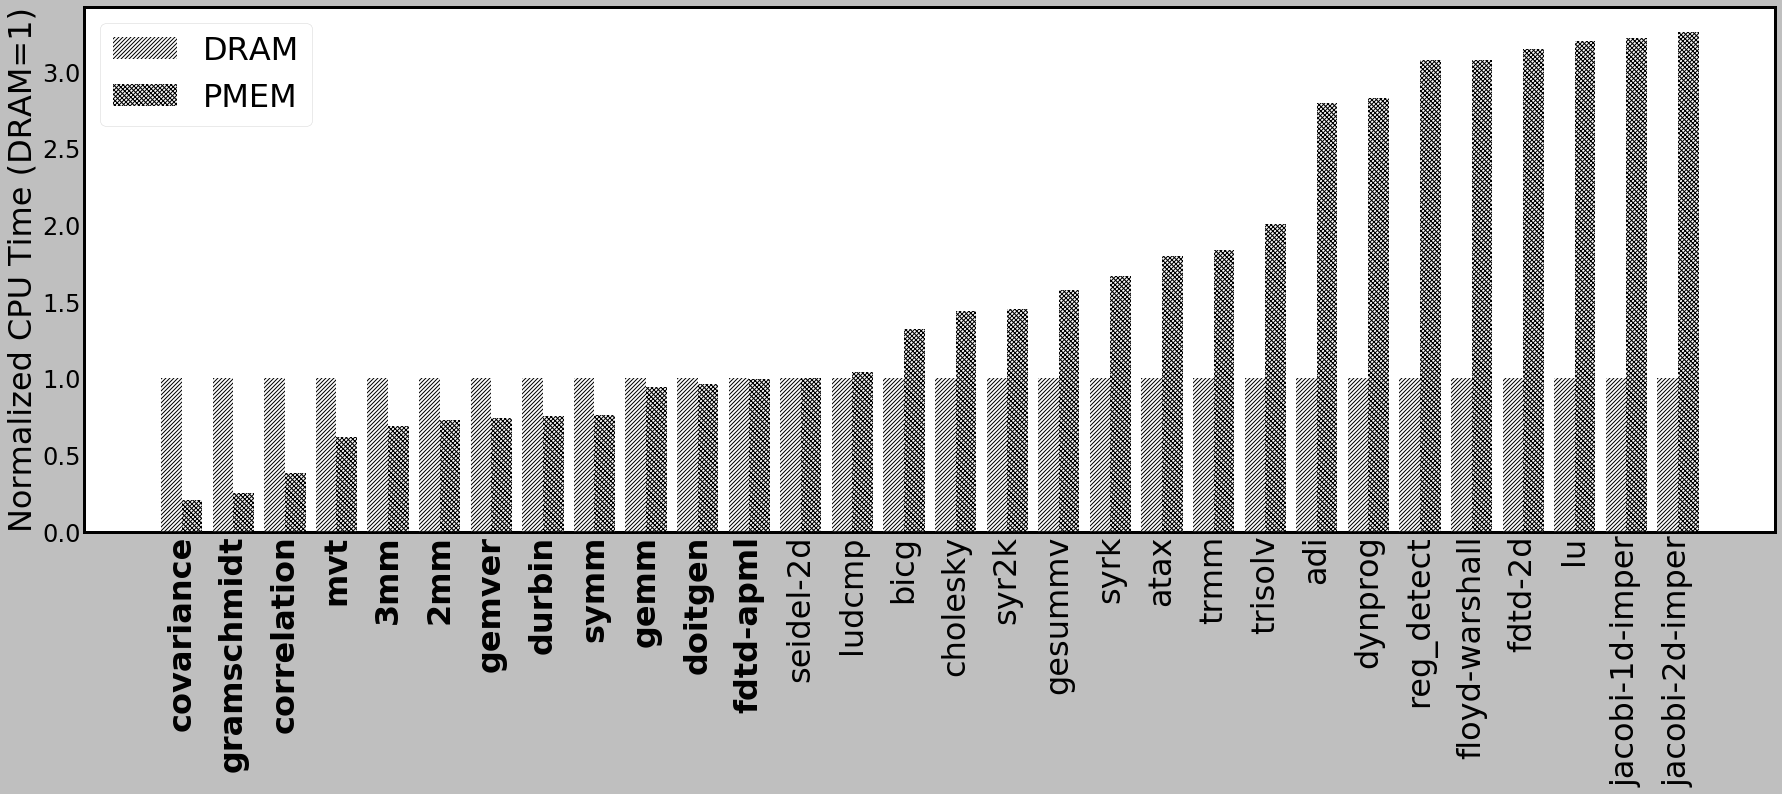

In [176]:
# this will reproduce the original data from Figure 1 using the latest results
pmem_norm_plot(ipmem2M_df, 'PMEM', 'pbfig-new.tex','pbfig-dec2019.png')

In [170]:
def pmem_dual_plot(df1, df2,label1="Label 1", label2="Label 2", tikzfile=None,pngfile=None,highlight_tests=[]):
    '''Given two dataframes, plot them relative to each other'''
    # TODO: again, should probably pass in labels
    plt.style.use('grayscale')
    n = len(df1.test.unique())
    assert n == len(df2.test.unique()), "Don't expect mismatched test sets"
    fig, ax = plt.subplots(figsize=(27,9))
    index = np.arange(n)
    bar_width = 0.40
    opacity = 0.2
    # http://olsgaard.dk/monochrome-black-white-plots-in-matplotlib.html
    bar_cycle = (cycler('hatch', ['//////', '//////\\\\\\\\\\', '++++++', '||||||','\///', 'xxx', '\\\\']) * cycler('color', 'w')*cycler('zorder', [10]))
    styles = bar_cycle()
    ax.grid(False)
    ax.bar(index, df2['normalized'].values, bar_width, alpha=opacity, **next(styles), label=label2)
    ax.bar(index+bar_width, df1['normalized'].values, bar_width, alpha=opacity, **next(styles), label=label1)
    #ax.set_xlabel('Polybench Tests (Normalized)', fontsize=24)
    ax.set_ylabel('Normalized CPU Time (DRAM=1)', fontsize=24)
    ax.set_xticks(index + 0.5 * bar_width)
    ax.set_xticklabels(df.test.unique())
    for xtl in ax.get_xticklabels():
        if xtl.get_text() in highlight_tests:
            xtl.set_fontweight('bold')
    ax.tick_params(labelsize=16)
    ax.legend(prop=dict(size=32))
    plt.xticks(rotation=90,fontsize=32)
    plt.yticks(fontsize=24)
    if tikzfile is not None: tikzplotlib.save(tikzfile)
    if pngfile is not None: plt.savefig(pngfile, bbox_inches="tight")
    plt.show()

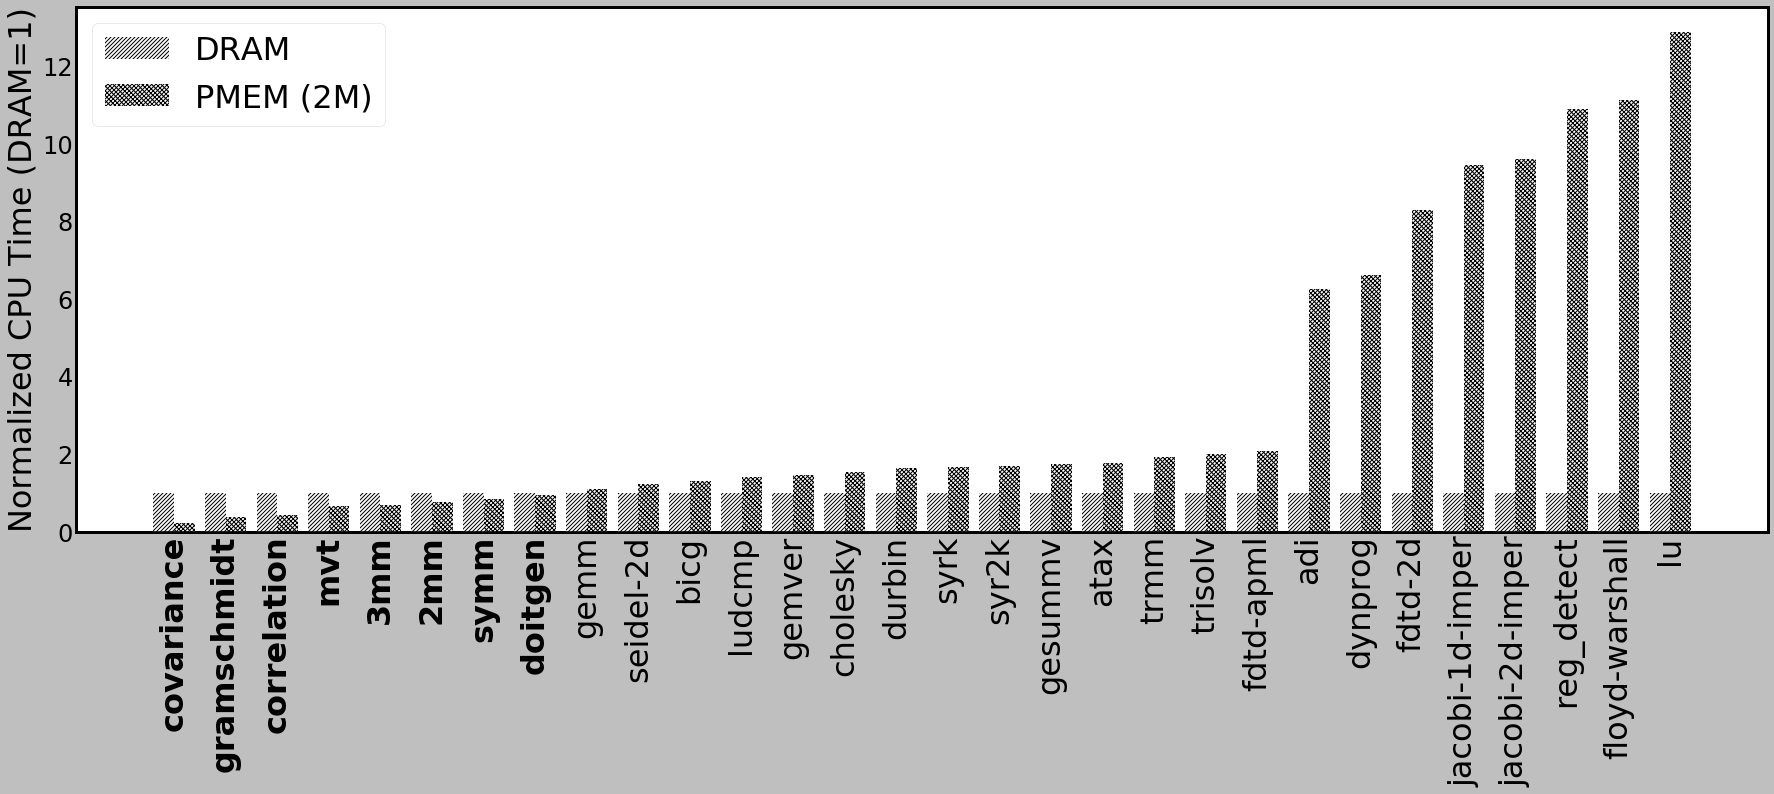

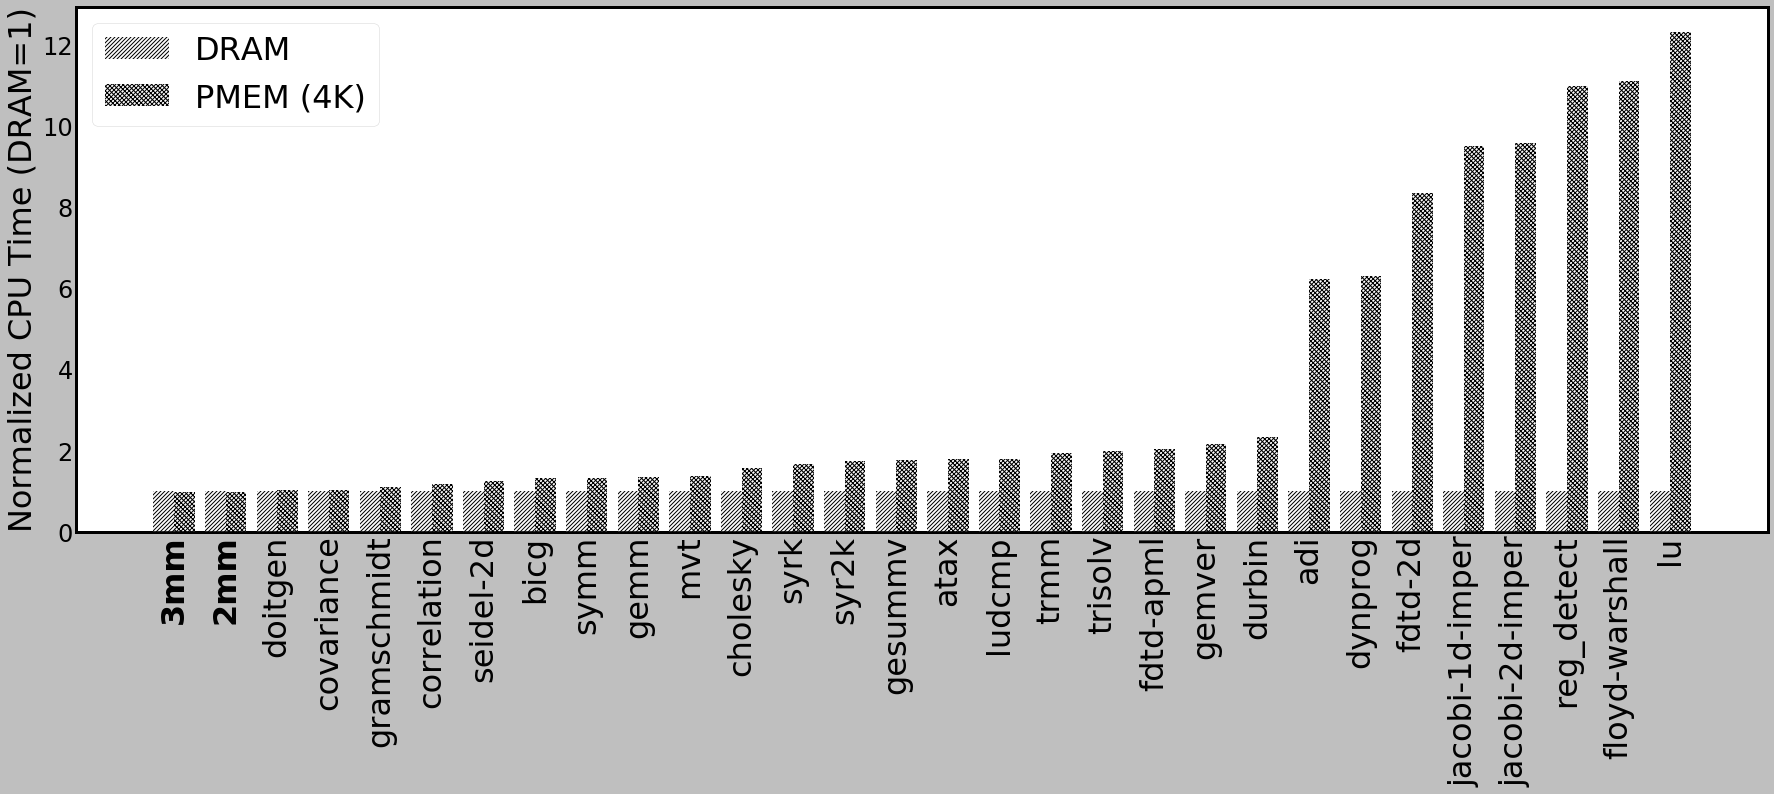

In [101]:
# this is non-interleaved PMEM against DRAM
pmem_norm_plot(df_sorted.loc[select(df_sorted, 'PMEM', '2M', False)], "PMEM (2M)",pngfile='pb-4k-DRAM-2M-PMEM.png')
pmem_norm_plot(df_sorted.loc[select(df_sorted, 'PMEM', '4K', False)], "PMEM (4K)",pngfile='pb-4k-DRAM-4K-PMEM.png')

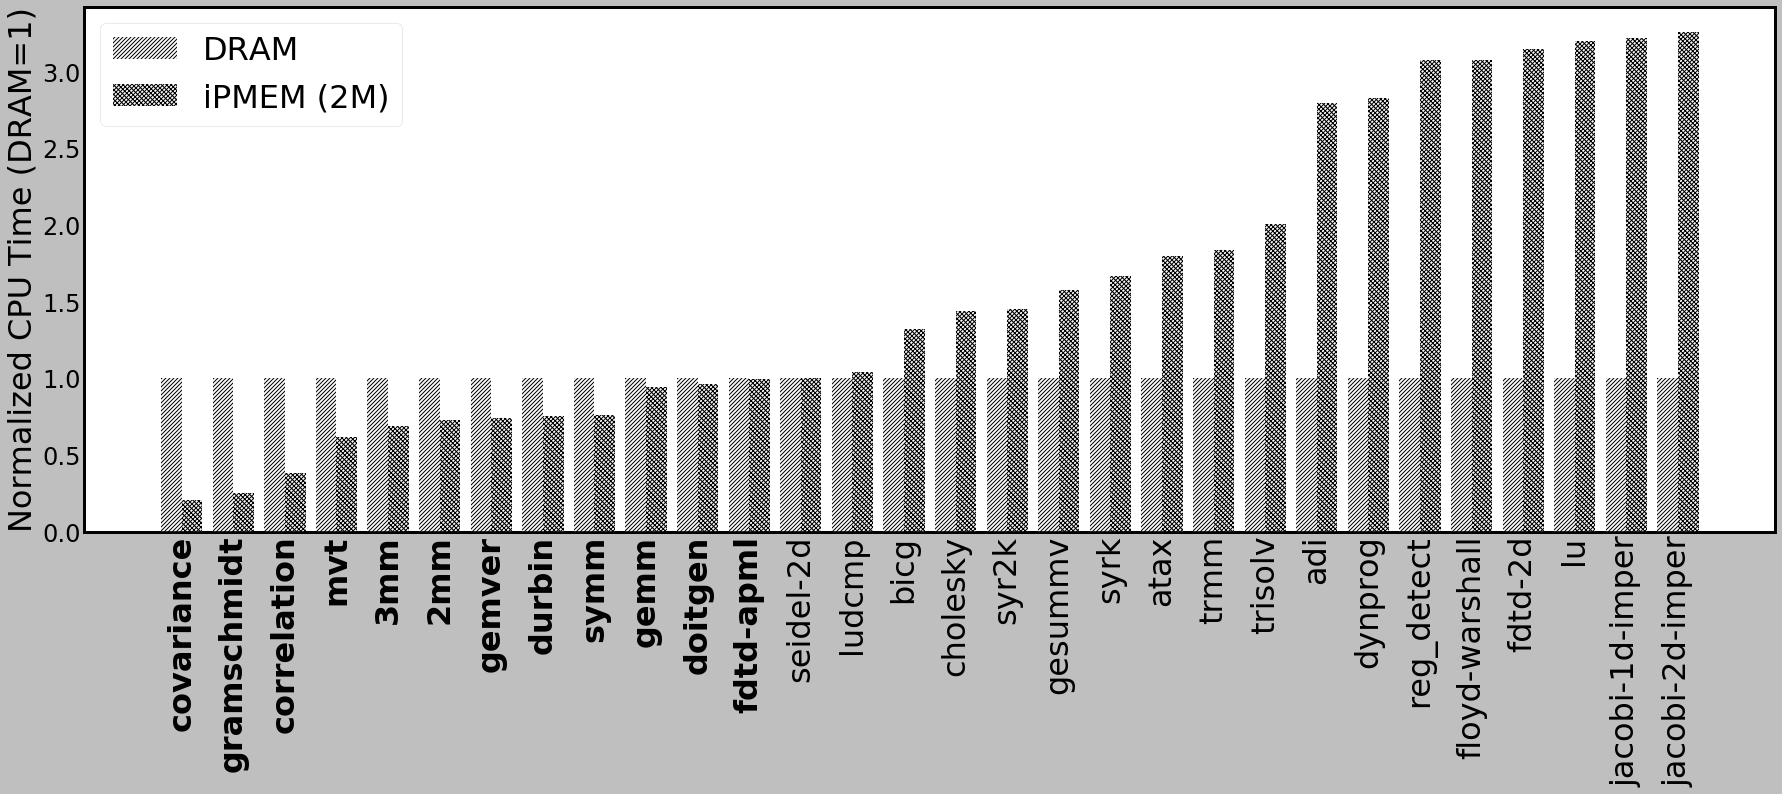

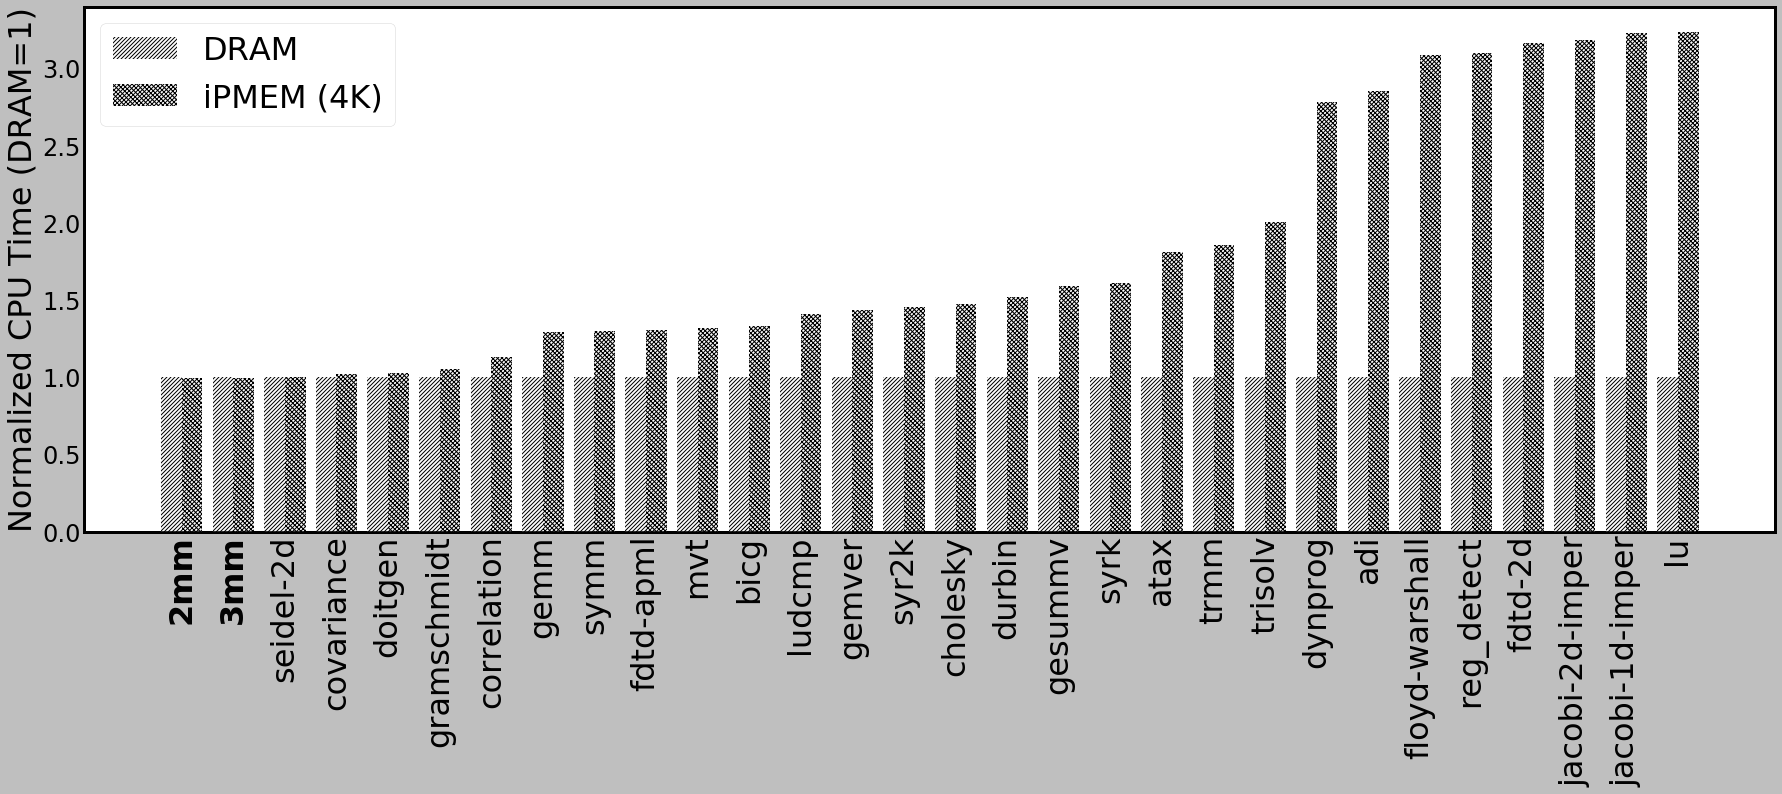

In [94]:
# show me interleaved PMEM with DRAM
pmem_norm_plot(df_sorted.loc[select(df_sorted, 'iPMEM', '2M', False)], "iPMEM (2M)",pngfile='pb-4k-DRAM-2M-iPMEM.png')
pmem_norm_plot(df_sorted.loc[select(df_sorted, 'iPMEM', '4K', False)], "iPMEM (4K)",pngfile='pb-4k-DRAM-4K-iPMEM.png')

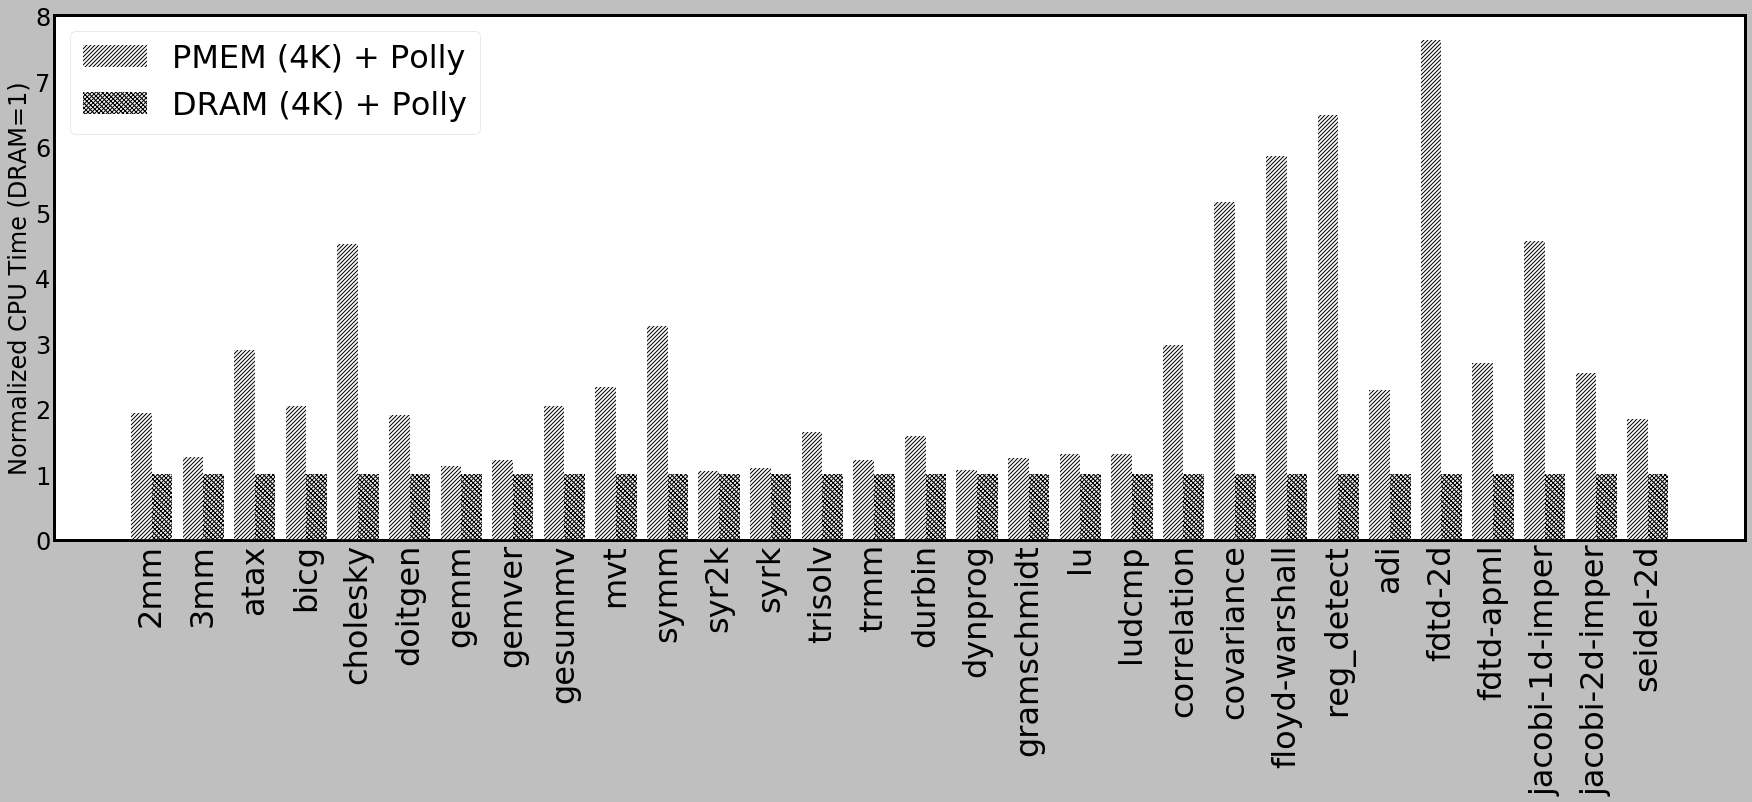

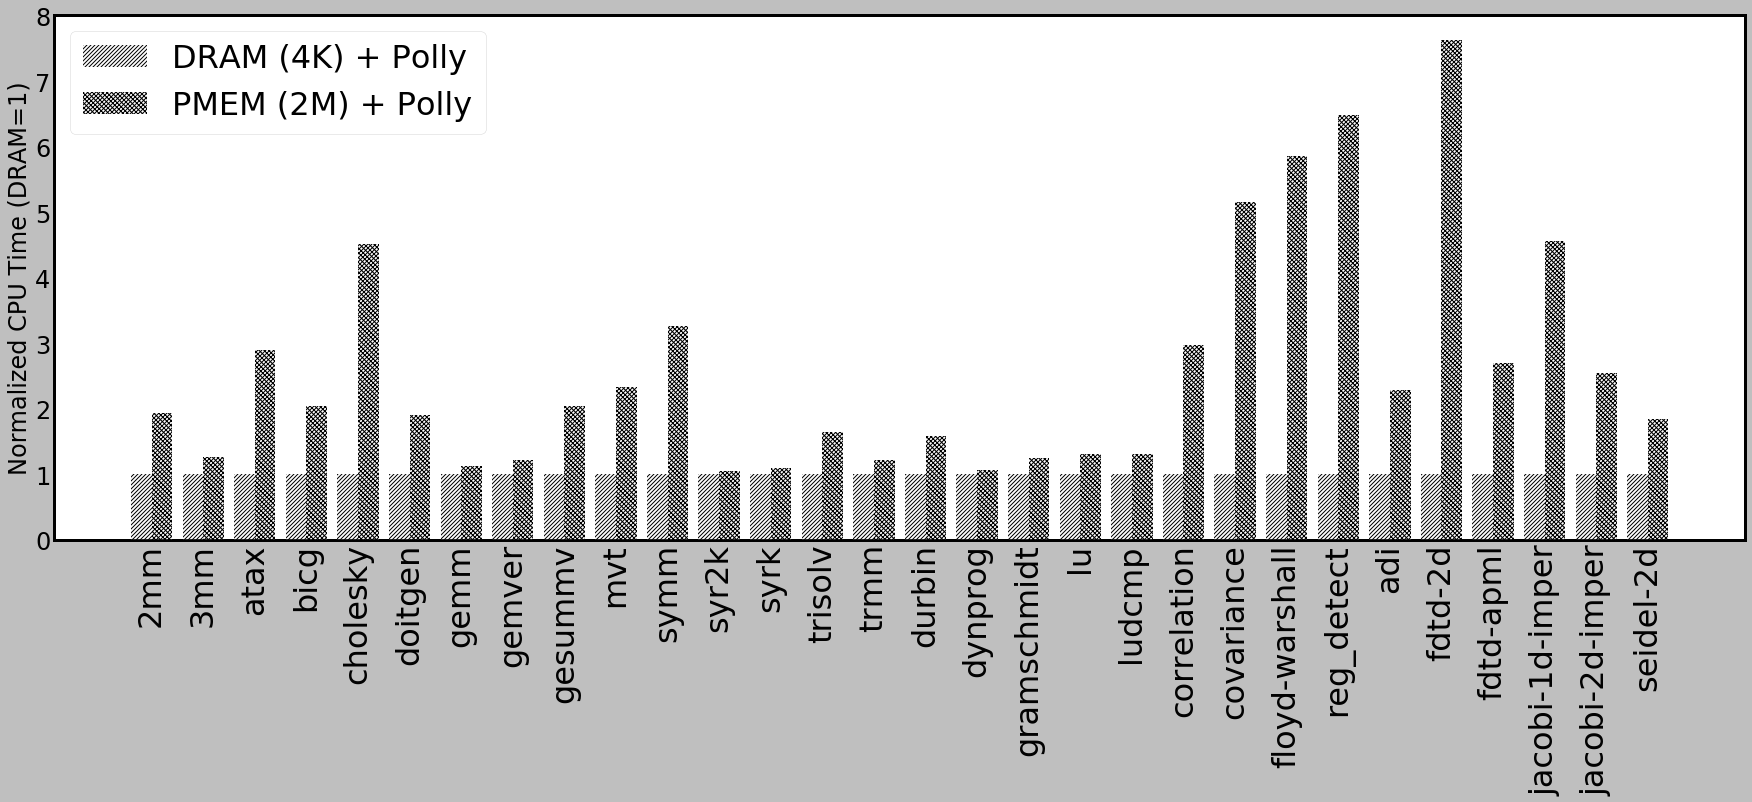

In [179]:
df_pmem_polly_sorted = df.sort_values(by=['polybench_time'])

# highlight_tests = [x for x in df.loc[df['normalized'] <= 1.0]['test']]

pmem_dual_plot(df_pmem_polly_sorted.loc[select(df_pmem_polly_sorted, 'DRAM', '4K', True)],
               df_pmem_polly_sorted[select(df_pmem_polly_sorted, 'PMEM', '4K', True)], 
               "DRAM (4K) + Polly", "PMEM (4K) + Polly")
pmem_dual_plot(df_pmem_polly_sorted[select(df_pmem_polly_sorted, 'PMEM', '4K', True)], 
               df_pmem_polly_sorted.loc[select(df_pmem_polly_sorted, 'DRAM', '4K', True)],
               "PMEM (2M) + Polly", "DRAM (4K) + Polly")
# pmem_norm_plot(df_pmem_polly_sorted.loc[select(df_pmem_polly_sorted, 'PMEM', '2M', True)], "PMEM (2M) + Polly", pngfile='pb-4K-DRAM-2M-iPMEM-polly.png')
# pmem_norm_plot(df_pmem_polly_sorted.loc[select(df_pmem_polly_sorted, 'PMEM', '4K', True)], "PMEM (4K) + Polly", pngfile='pb-4K-DRAM-4K-iPMEM-polly.png')

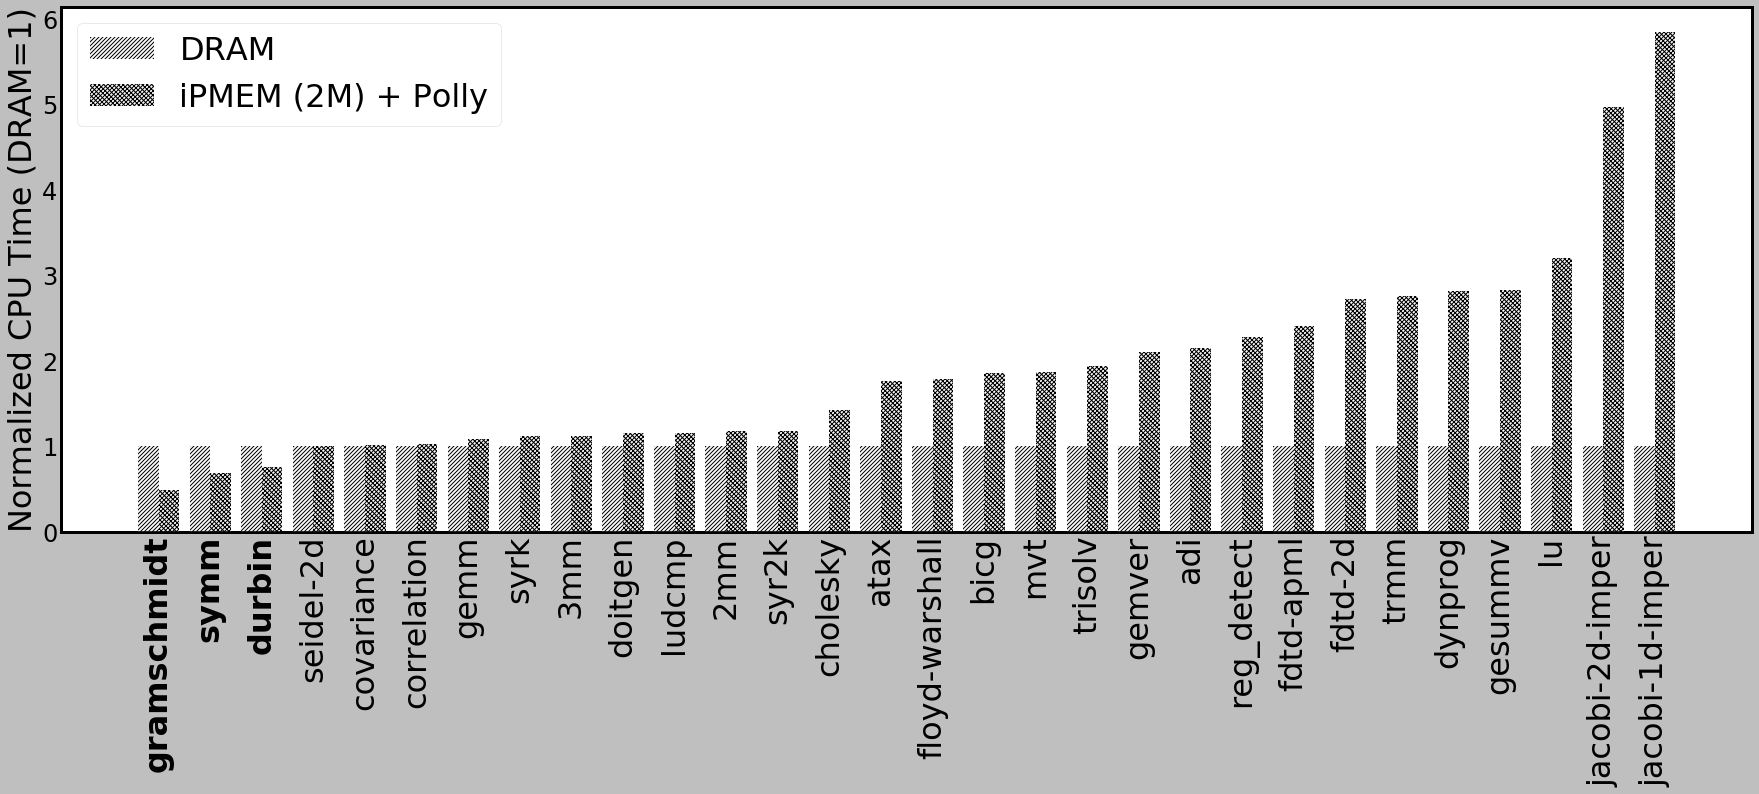

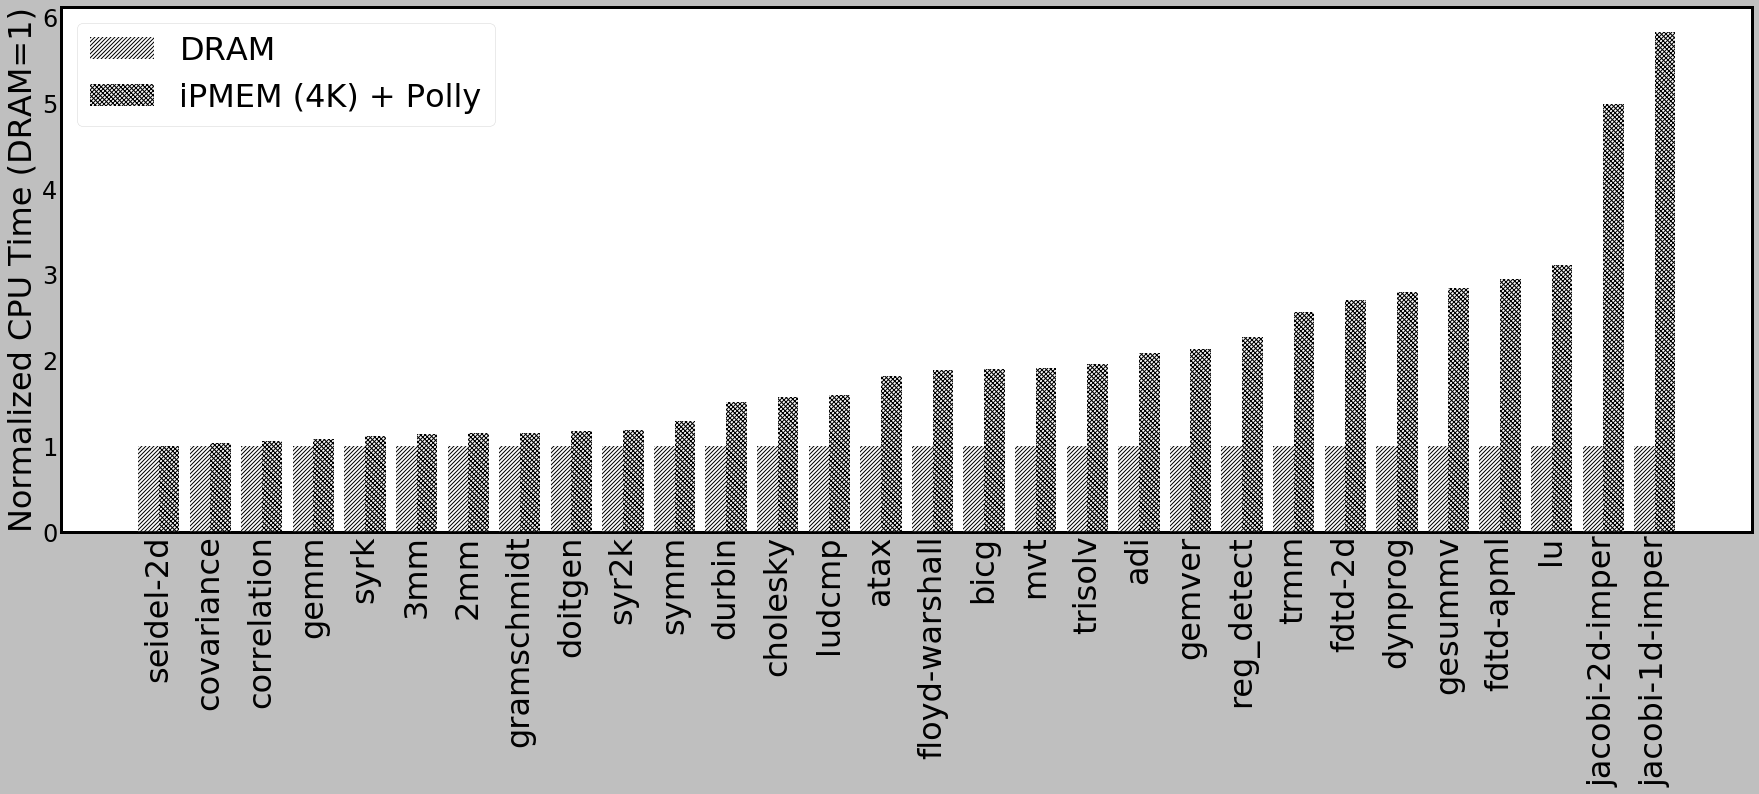

In [96]:
# this is interleaved PMEM against DRAM + Polly
pmem_norm_plot(df_sorted.loc[select(df_sorted, 'iPMEM', '2M', True)], "iPMEM (2M) + Polly")
pmem_norm_plot(df_sorted.loc[select(df_sorted, 'iPMEM', '4K', True)], "iPMEM (4K) + Polly")

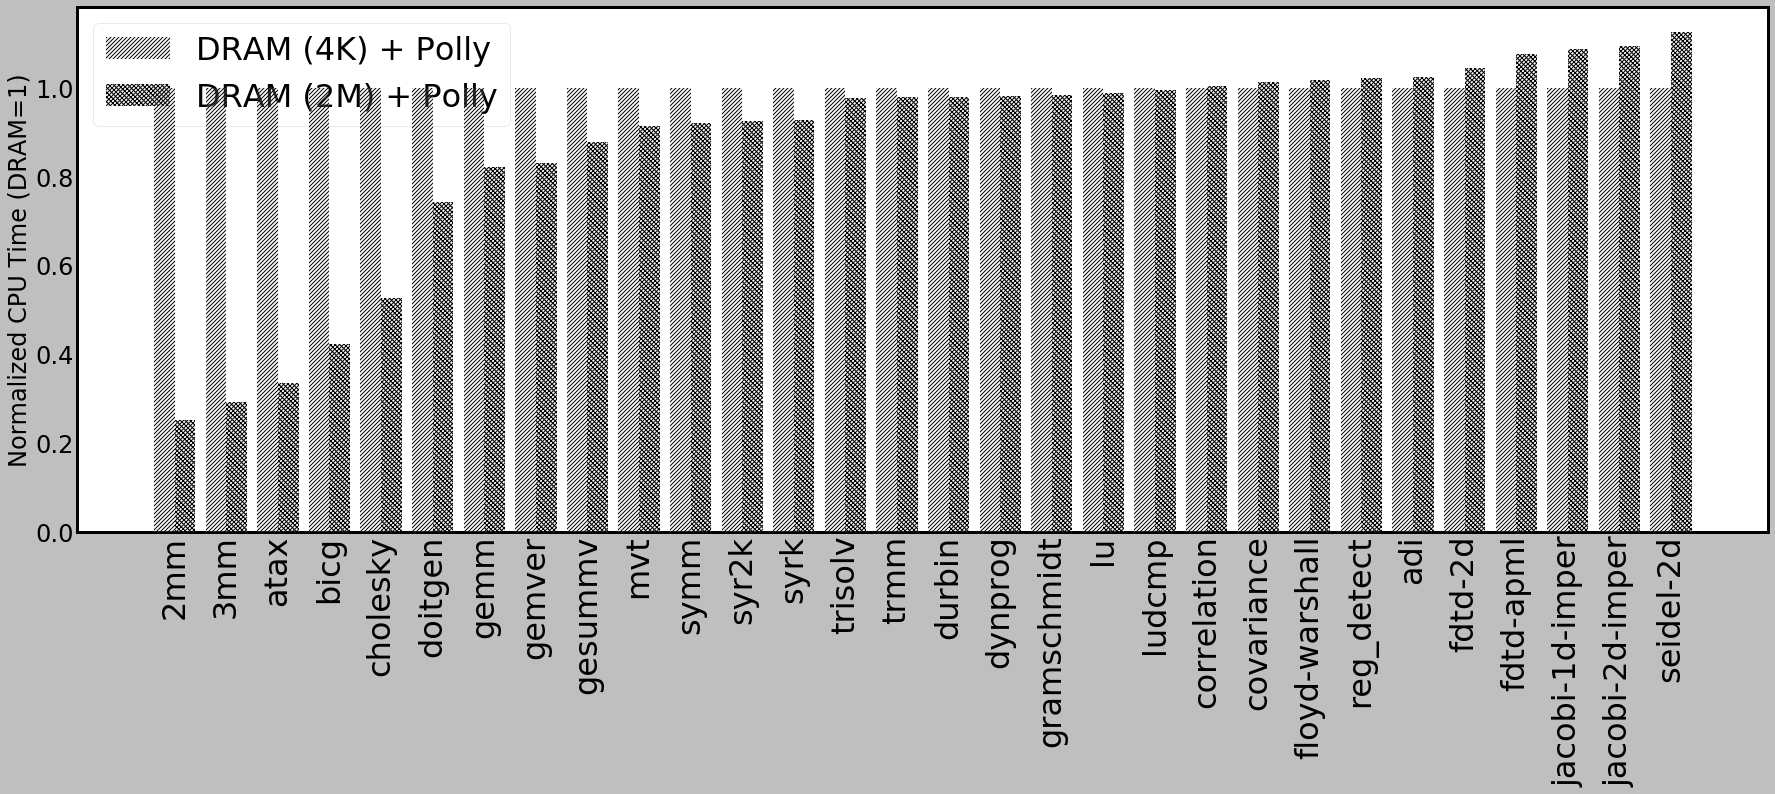

In [102]:
# note labels are wrong

pmem_dual_plot(df_sorted.loc[select(df_sorted, 'DRAM', '2M', True)], 
               df_sorted.loc[select(df_sorted, 'DRAM', '4K', True)],
               "DRAM (2M) + Polly", "DRAM (4K) + Polly")

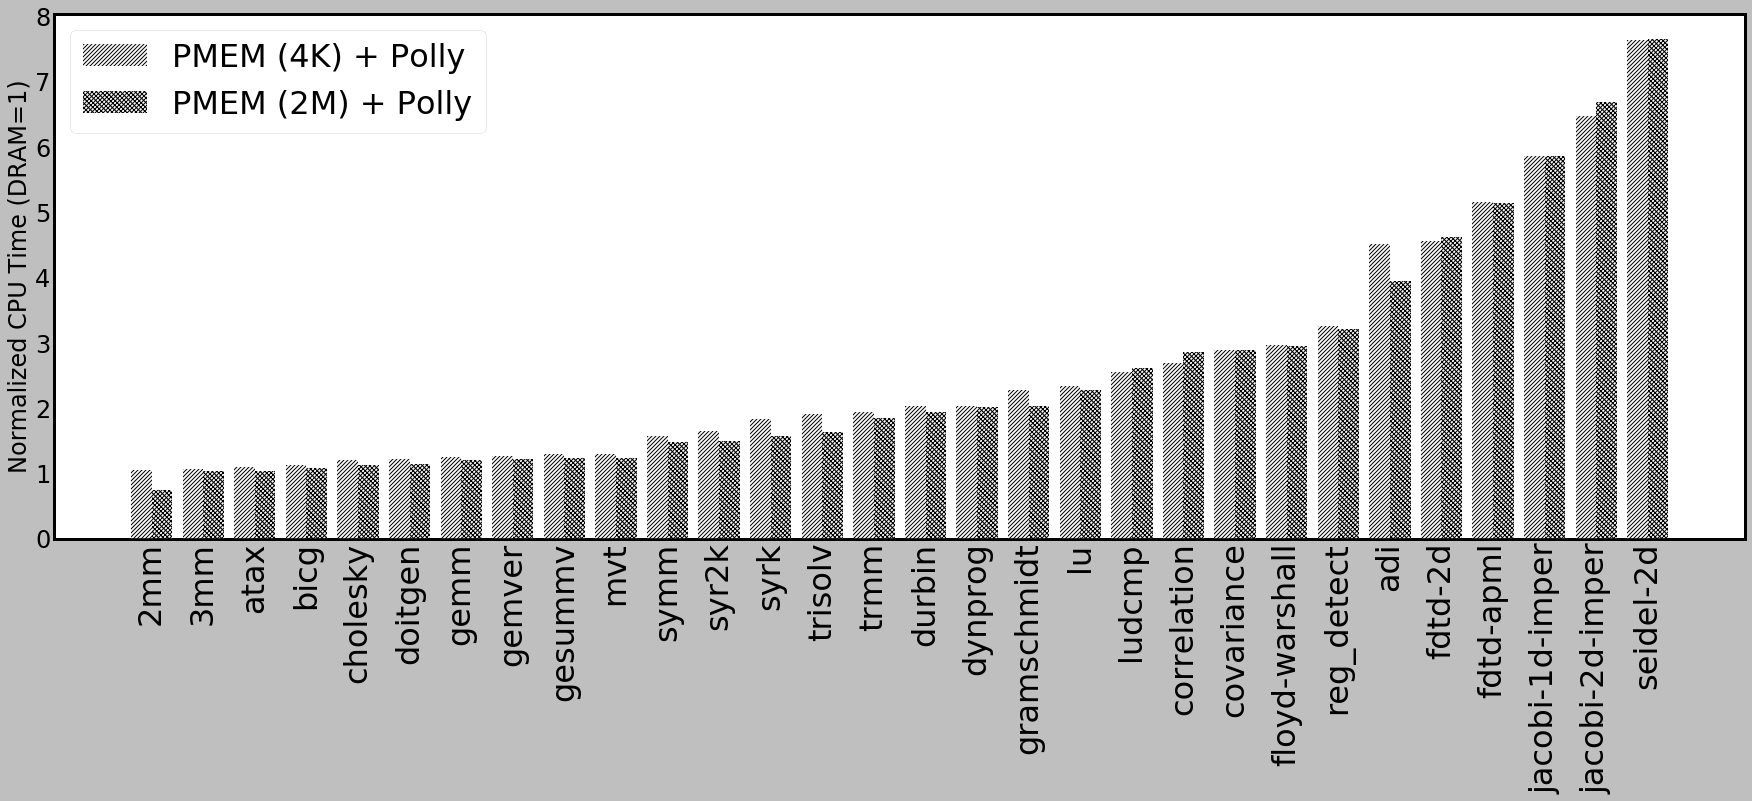

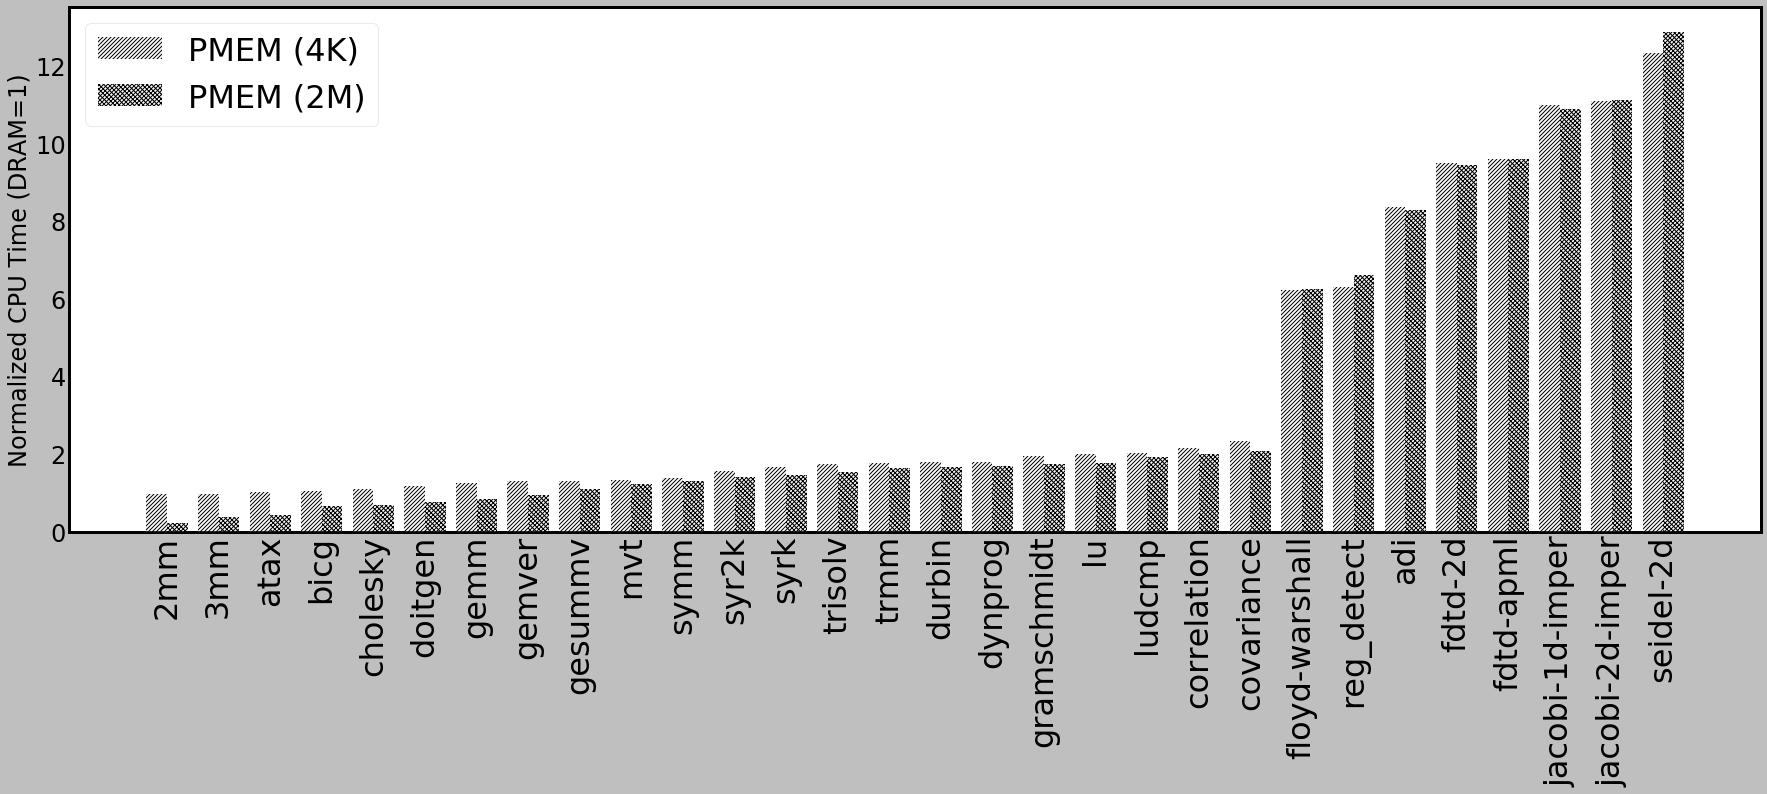

In [103]:
# note labels are wrong

pmem_dual_plot(df_sorted.loc[select(df_sorted, 'PMEM', '2M', True)], 
               df_sorted.loc[select(df_sorted, 'PMEM', '4K', True)],
              "PMEM (2M) + Polly", "PMEM (4K) + Polly")
pmem_dual_plot(df_sorted.loc[select(df_sorted, 'PMEM', '2M', False)], 
               df_sorted.loc[select(df_sorted, 'PMEM', '4K', False)],
              "PMEM (2M)", "PMEM (4K)")

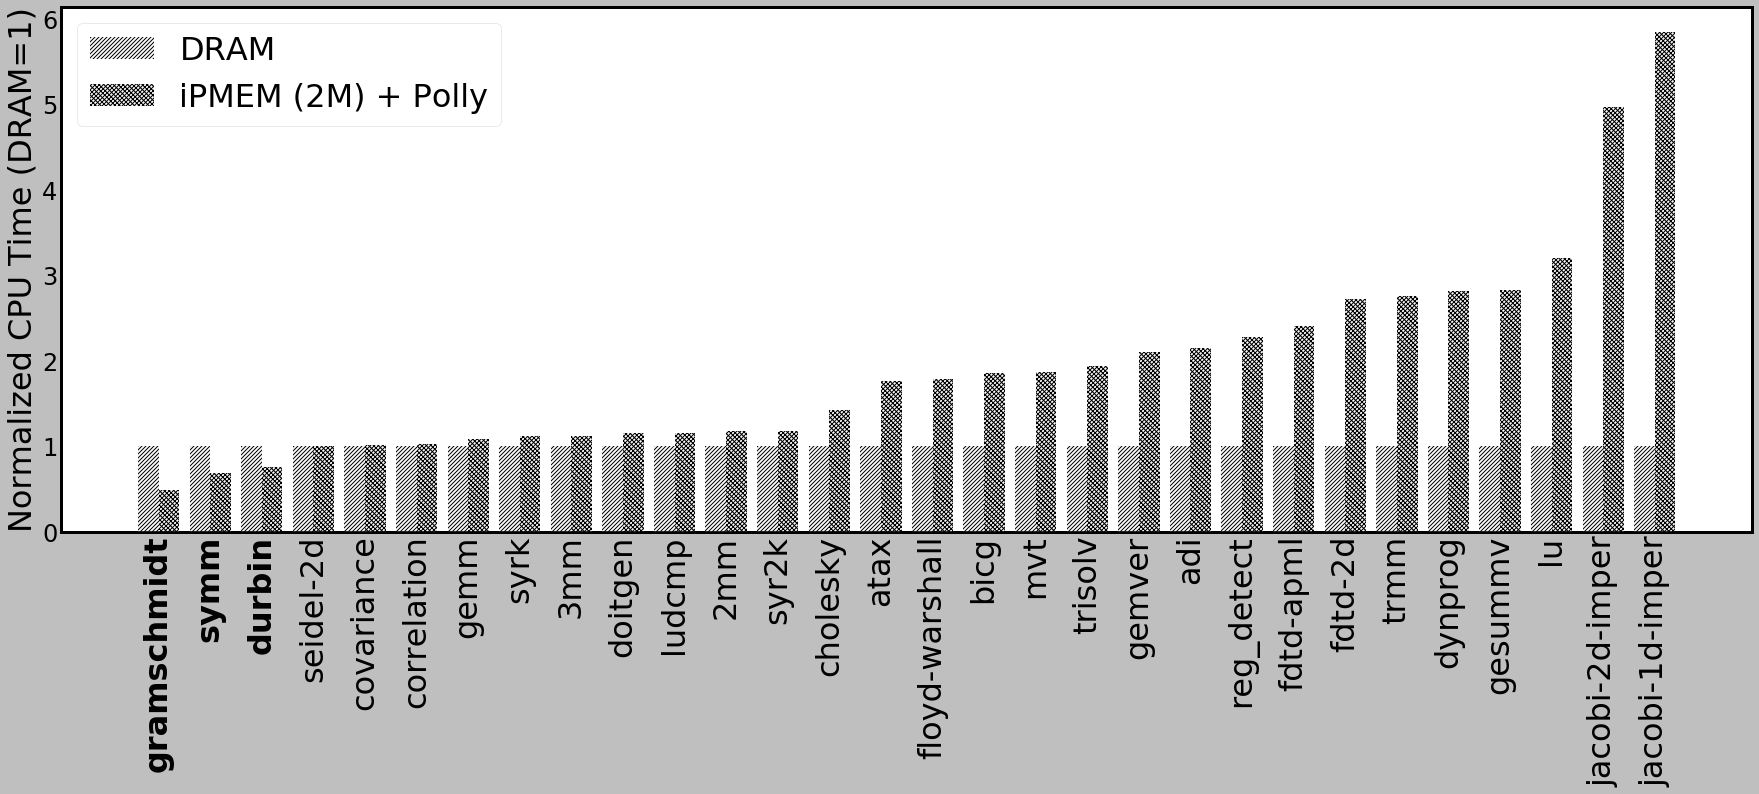

In [104]:
pmem_norm_plot(df_sorted.loc[select(df_sorted, 'iPMEM', '2M', True)], "iPMEM (2M) + Polly")

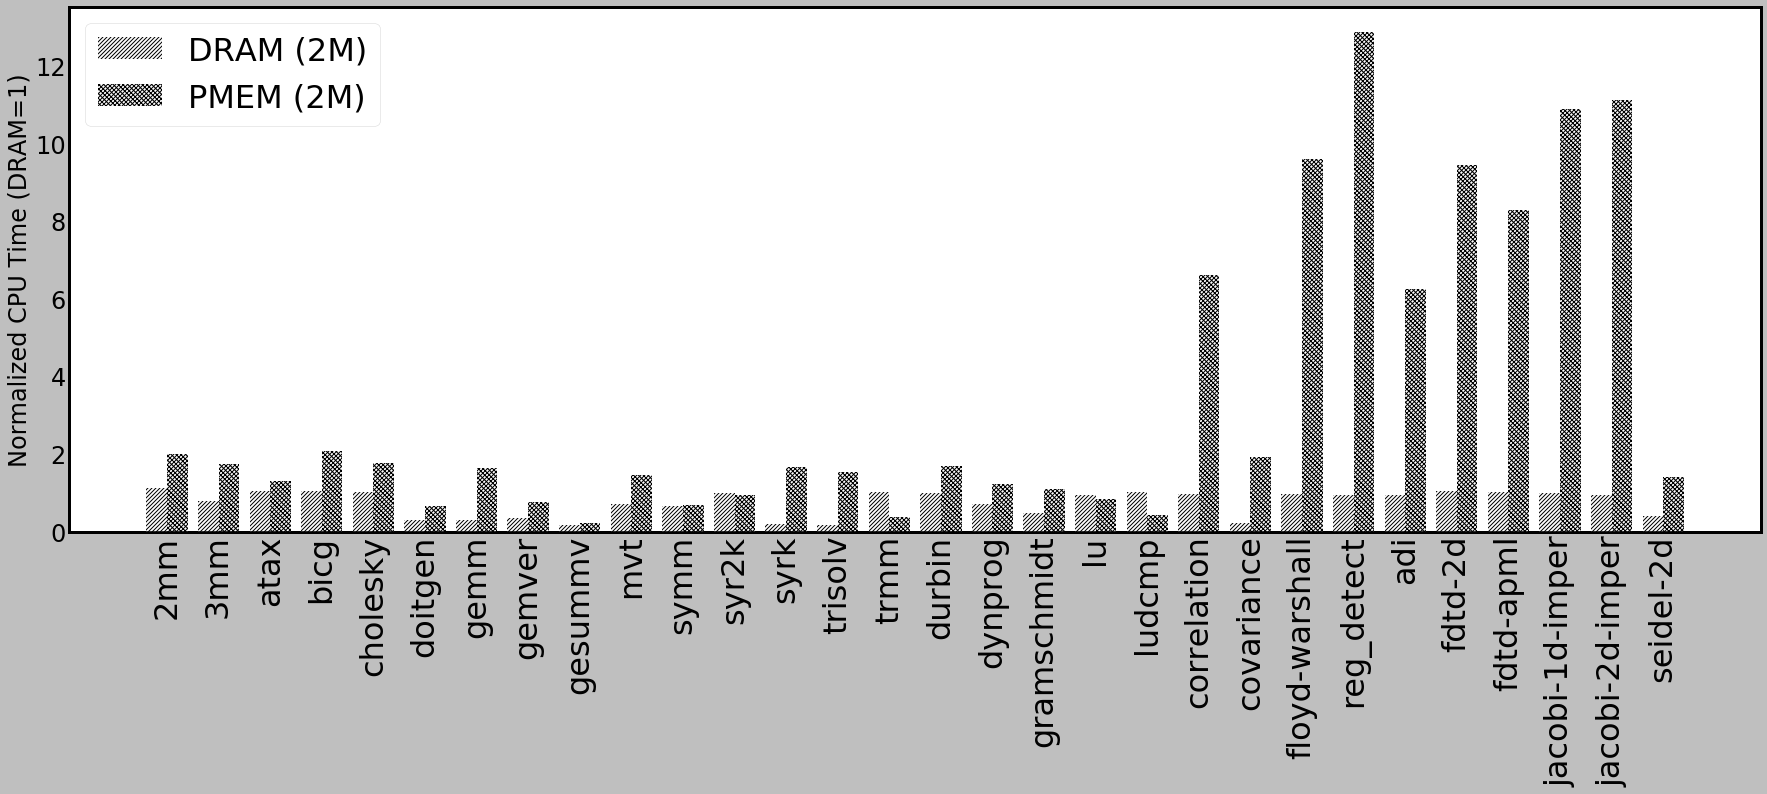

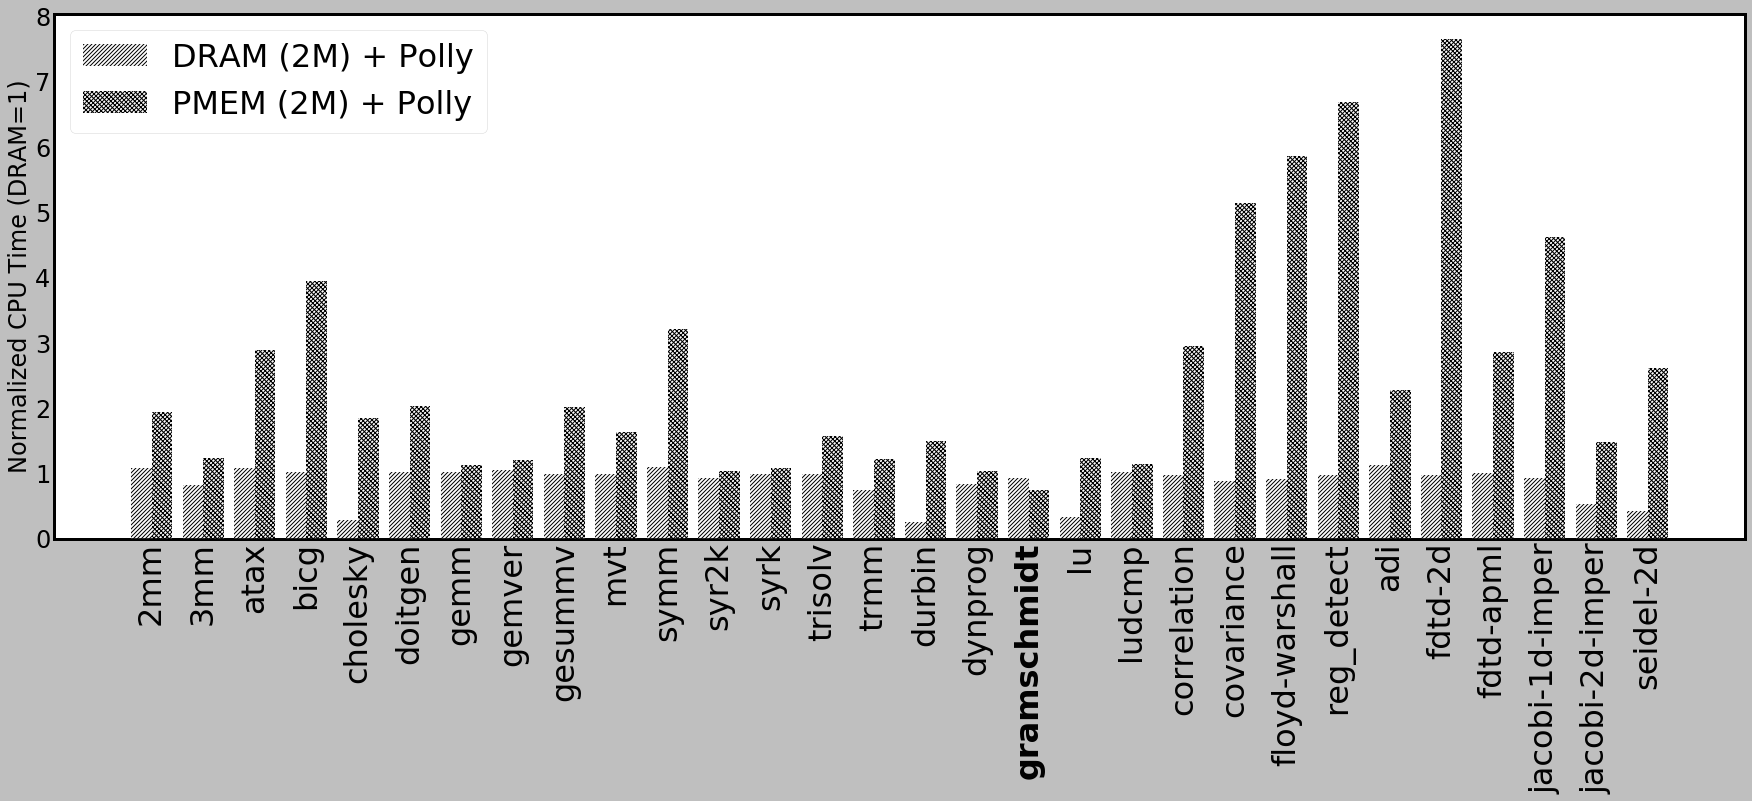

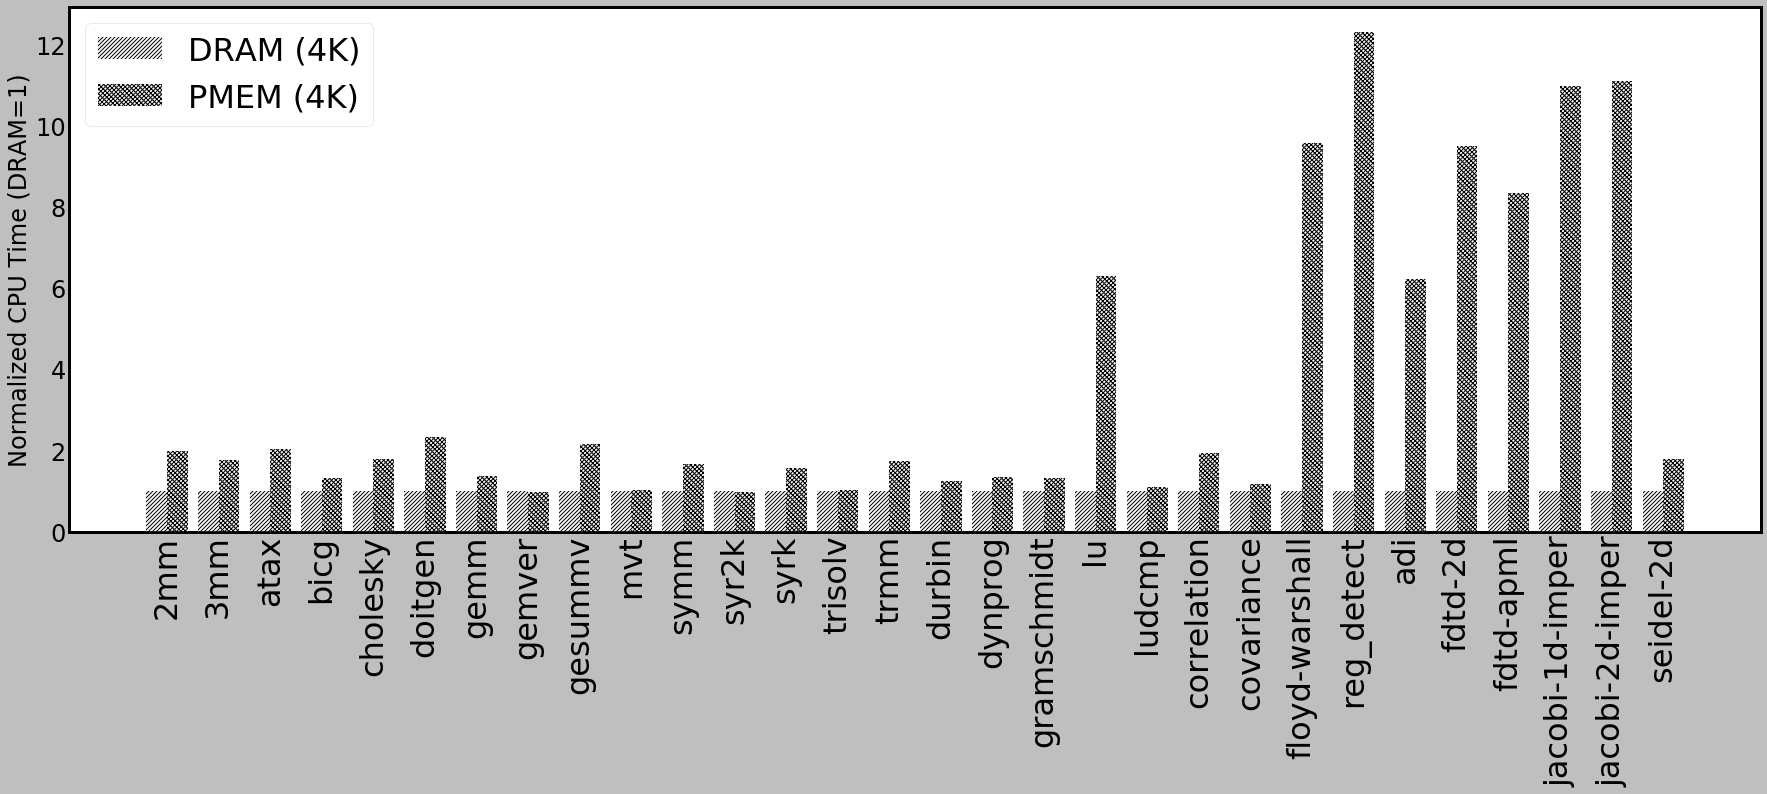

In [269]:
pmem_dual_plot(df_sorted.loc[select(df_sorted, 'PMEM', '2M', False)], 
               df_sorted.loc[select(df_sorted, 'DRAM', '2M', False)],
              "PMEM (2M)", "DRAM (2M)")
pmem_dual_plot(df_sorted.loc[select(df_sorted, 'PMEM', '2M', True)], 
               df_sorted.loc[select(df_sorted, 'DRAM', '2M', True)],
              "PMEM (2M) + Polly", "DRAM (2M) + Polly", highlight_tests=['gramschmidt'])
pmem_dual_plot(df_sorted.loc[select(df_sorted, 'PMEM', '4K', False)], 
               df_sorted.loc[select(df_sorted, 'DRAM', '4K', False)],
              "PMEM (4K)", "DRAM (4K)")

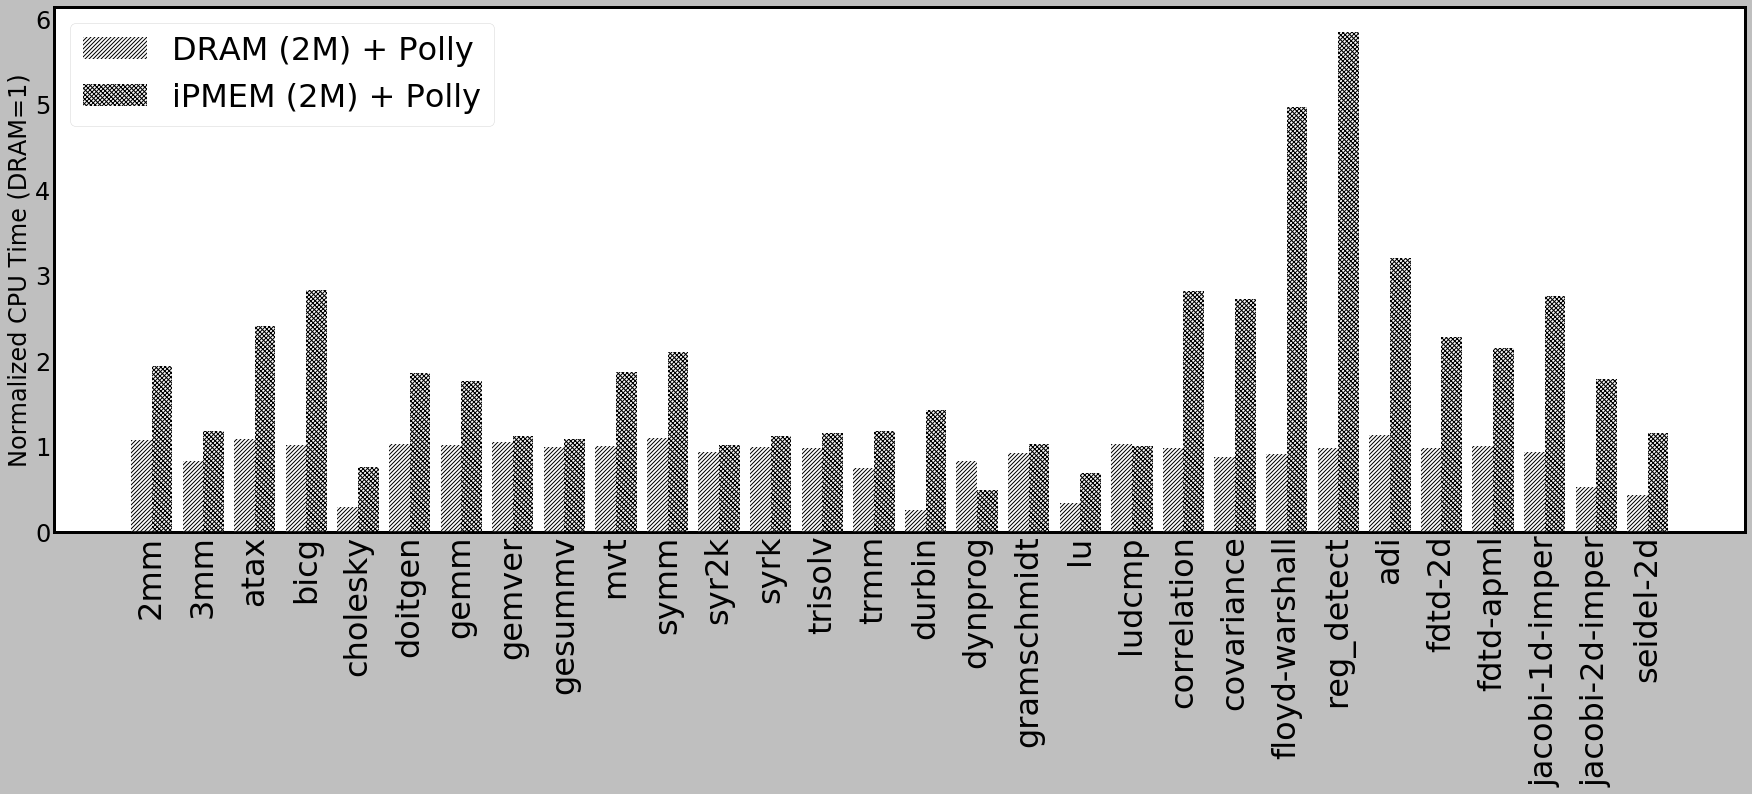

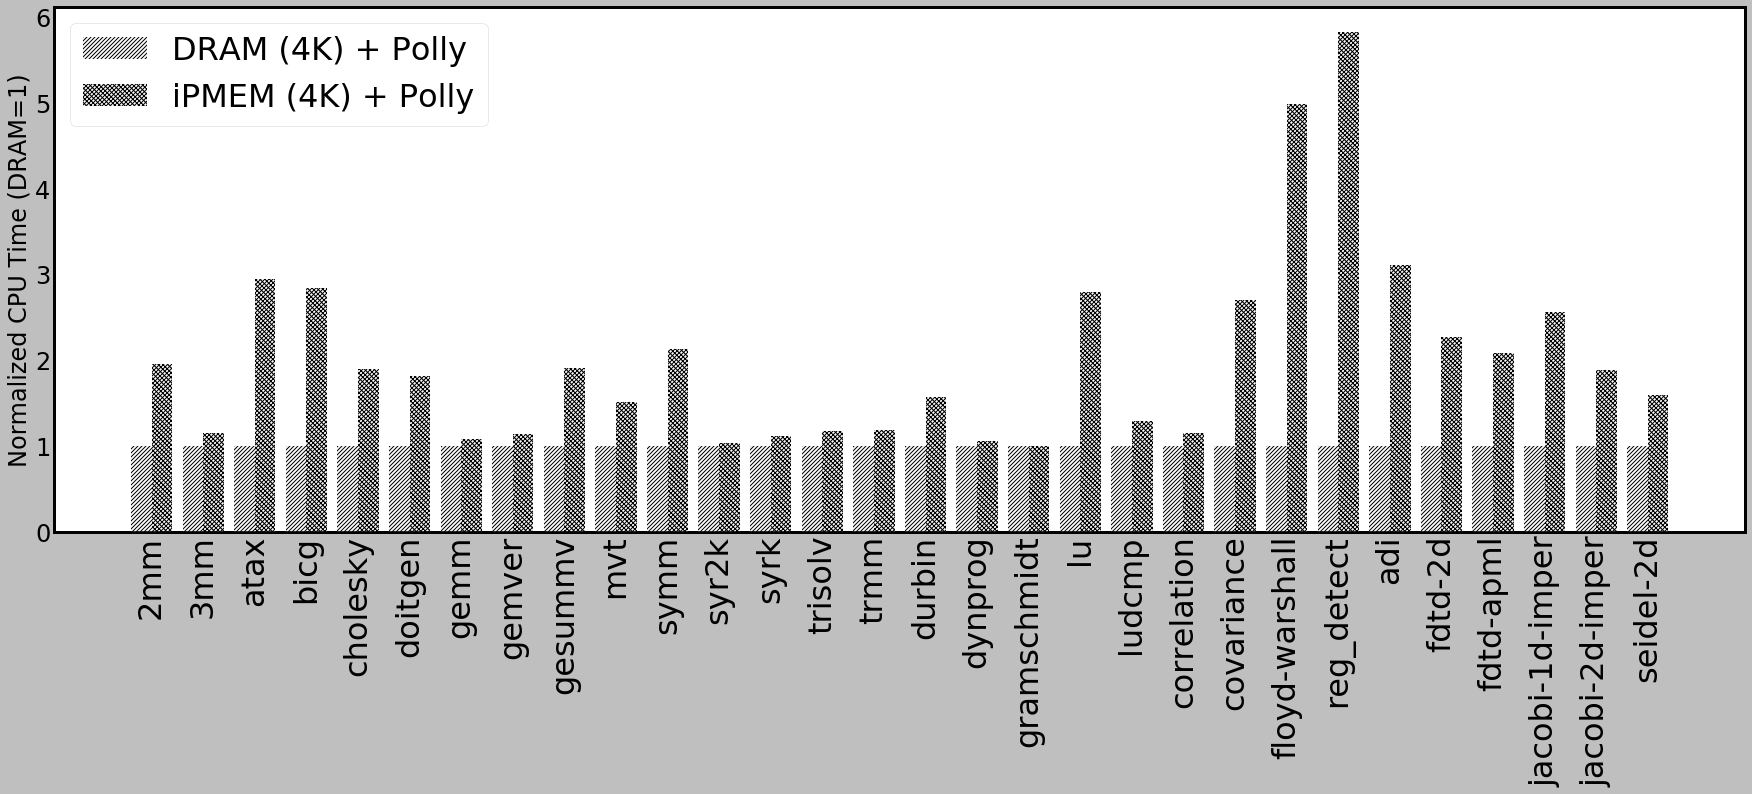

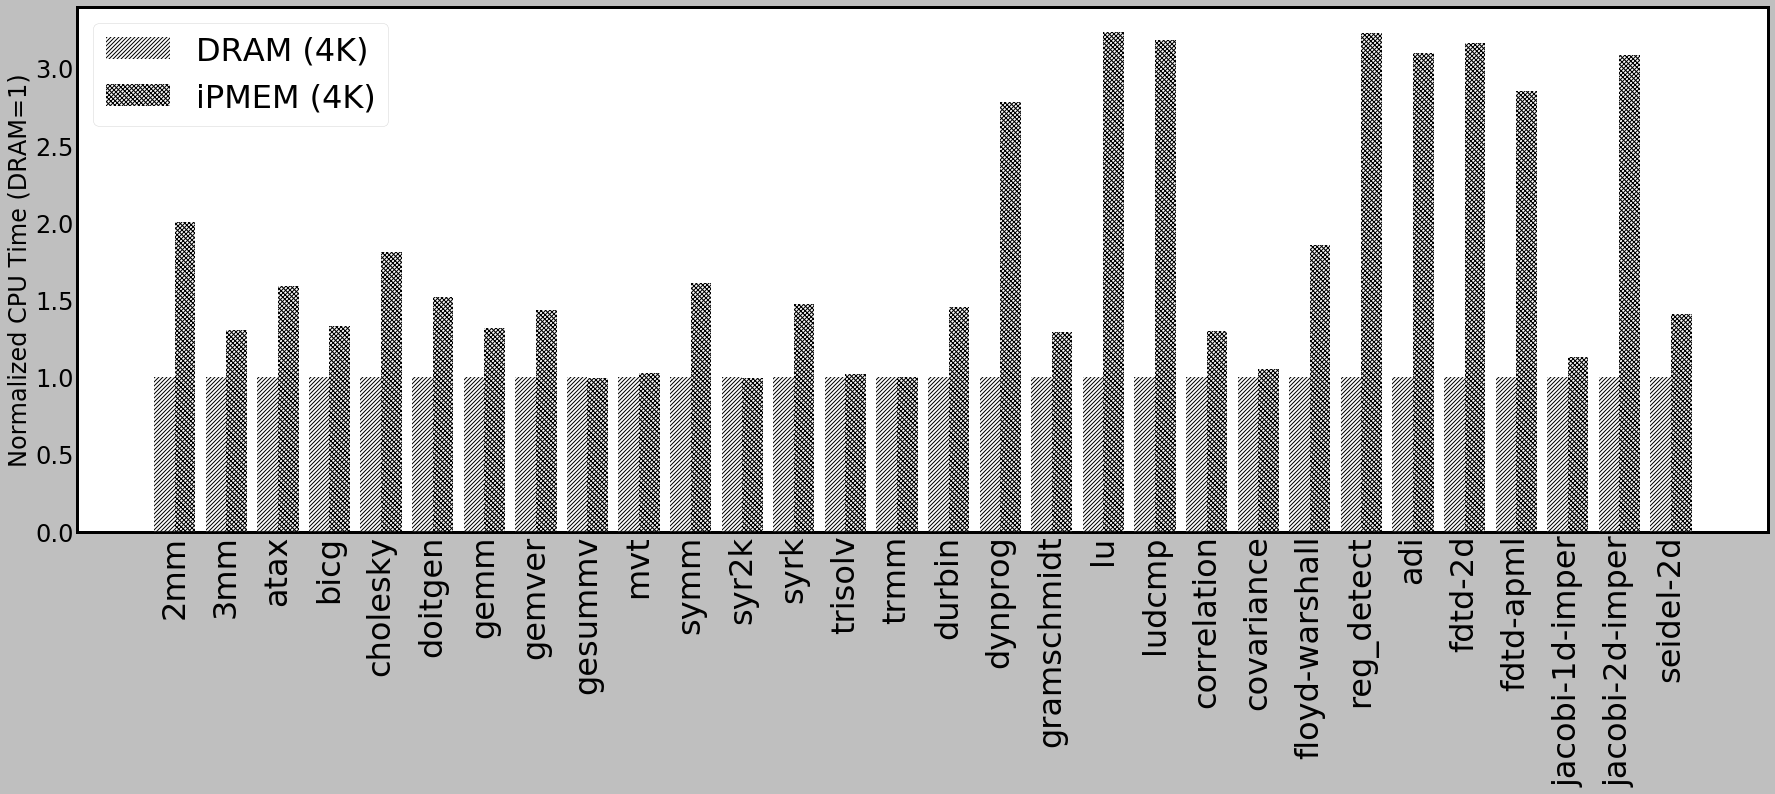

In [163]:
pmem_dual_plot(df_sorted.loc[select(df_sorted, 'iPMEM', '2M', True)], 
               df_sorted.loc[select(df_sorted, 'DRAM', '2M', True)],
              "iPMEM (2M) + Polly", "DRAM (2M) + Polly")
pmem_dual_plot(df_sorted.loc[select(df_sorted, 'iPMEM', '4K', True)], 
               df_sorted.loc[select(df_sorted, 'DRAM', '4K', True)],
              "iPMEM (4K) + Polly", "DRAM (4K) + Polly")
pmem_dual_plot(df_sorted.loc[select(df_sorted, 'iPMEM', '4K', False)], 
               df_sorted.loc[select(df_sorted, 'DRAM', '4K', False)],
              "iPMEM (4K)", "DRAM (4K)")

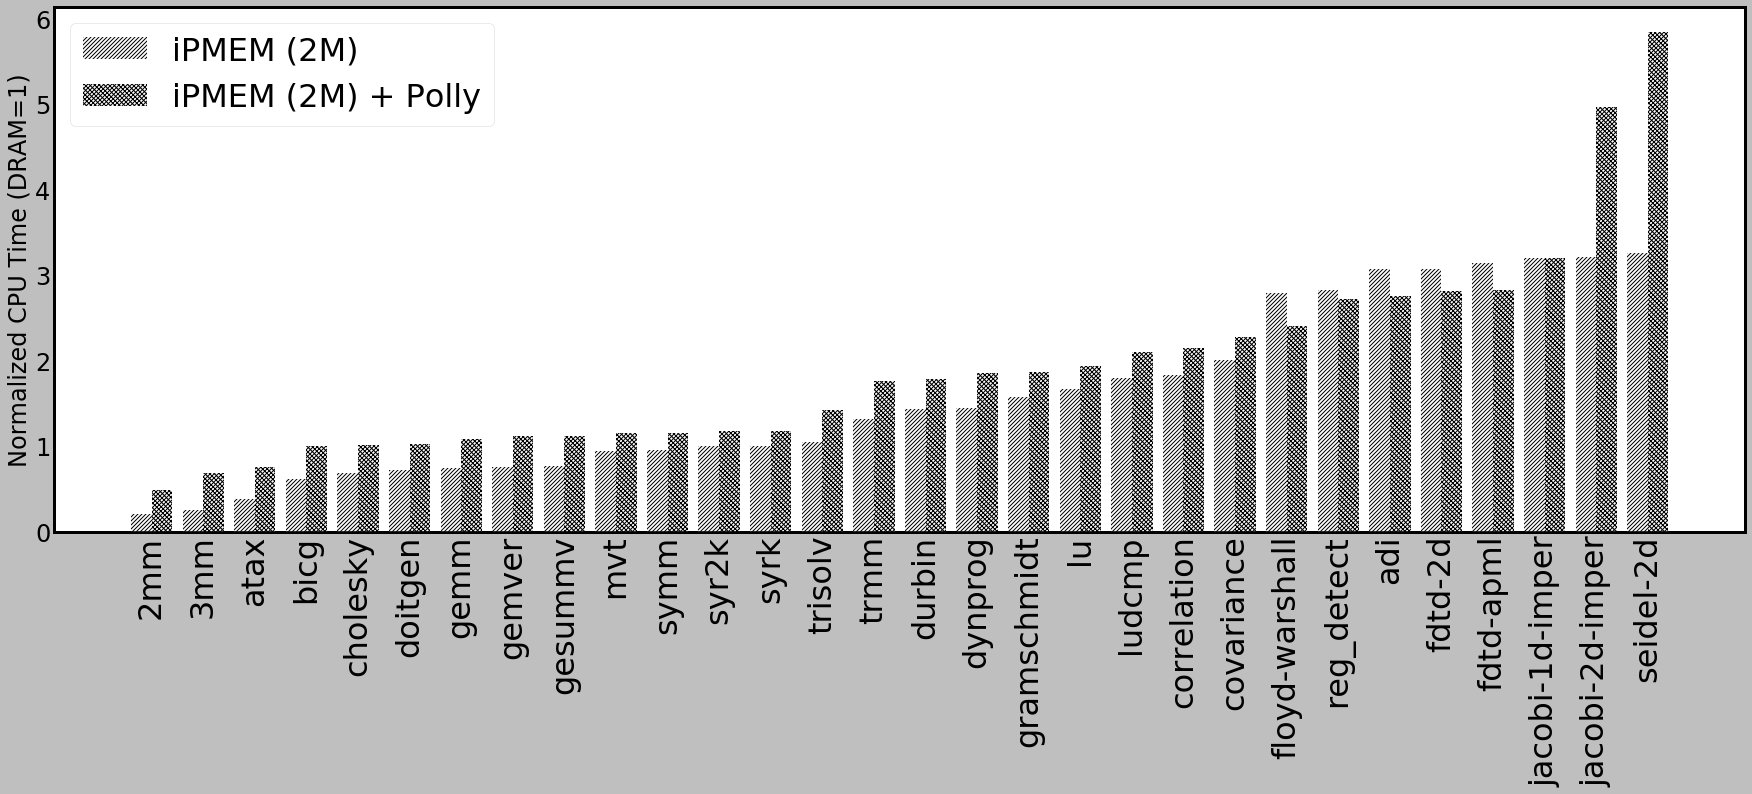

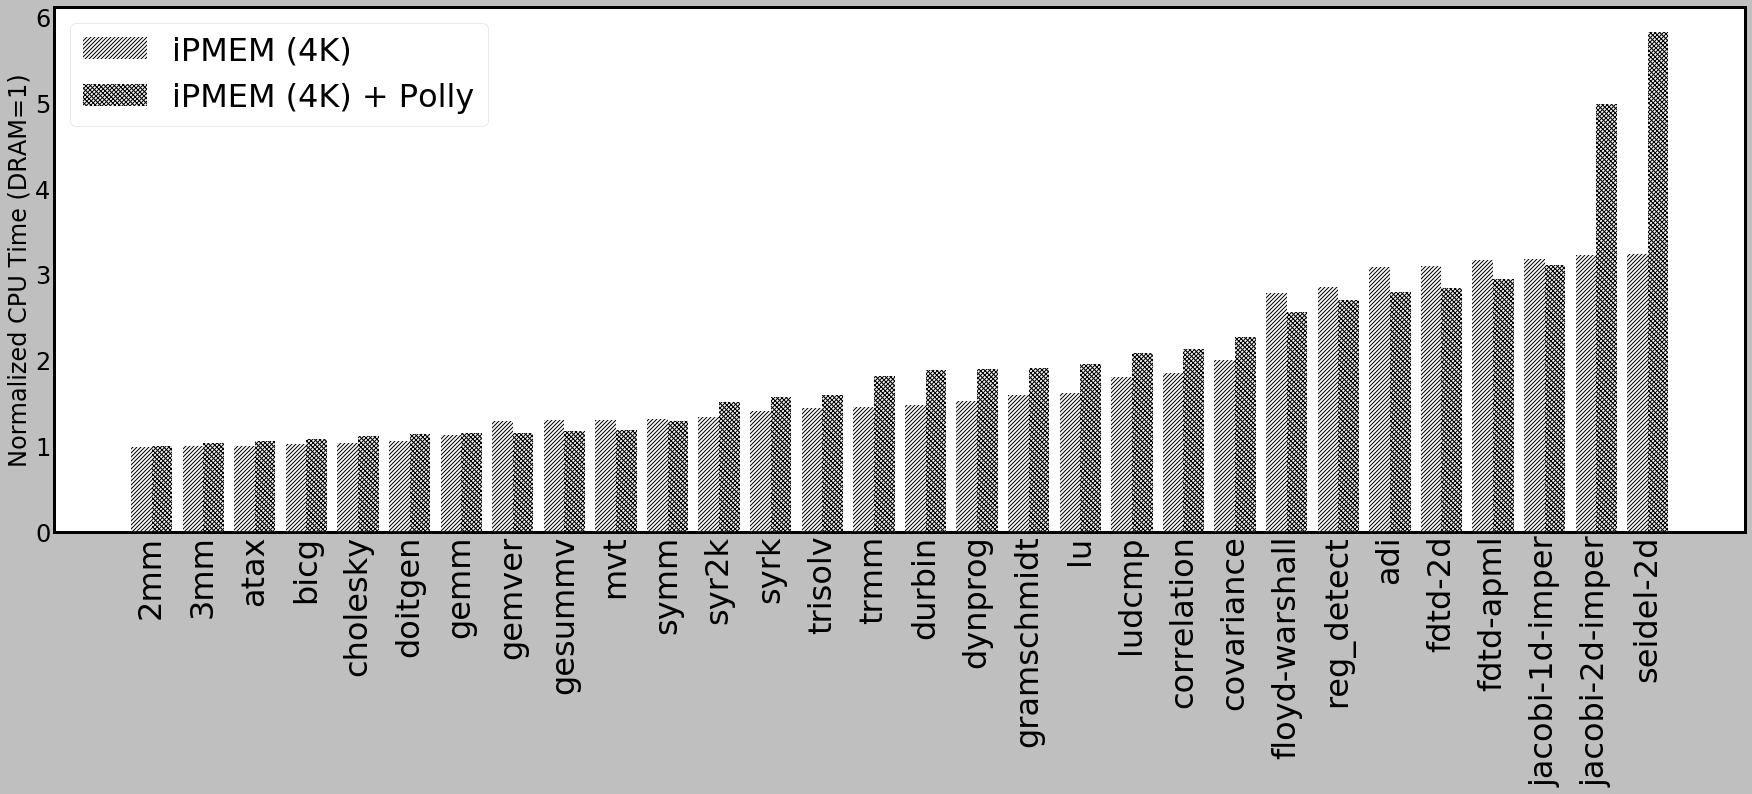

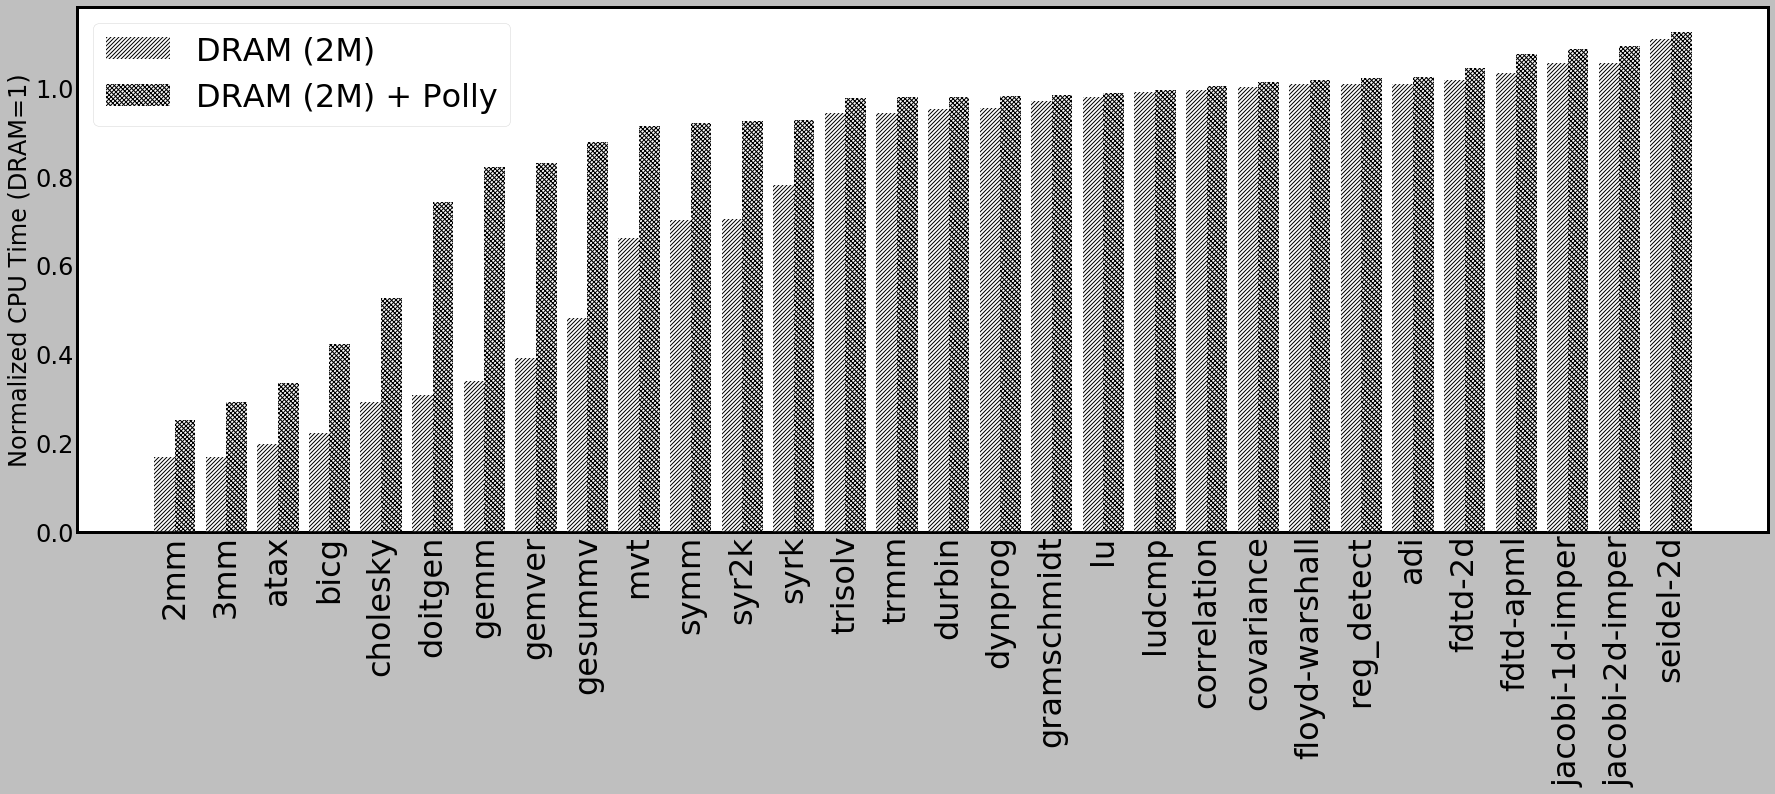

In [107]:
pmem_dual_plot(df_sorted.loc[select(df_sorted, 'iPMEM', '2M', True)], 
               df_sorted.loc[select(df_sorted, 'iPMEM', '2M', False)],
              "iPMEM (2M) + Polly", "iPMEM (2M)")
pmem_dual_plot(df_sorted.loc[select(df_sorted, 'iPMEM', '4K', True)], 
               df_sorted.loc[select(df_sorted, 'iPMEM', '4K', False)],
              "iPMEM (4K) + Polly", "iPMEM (4K)")
# 4K DRAM doesn't work, since it is normalized against 4K
pmem_dual_plot(df_sorted.loc[select(df_sorted, 'DRAM', '2M', True)], 
               df_sorted.loc[select(df_sorted, 'DRAM', '2M', False)],
              "DRAM (2M) + Polly", "DRAM (2M)")

In [271]:
def pmem_dual_plot2(df1, df2,label1="Label 1", label2="Label 2",field='normalized', ylabel="Y axis Label",tikzfile=None,pngfile=None,highlight_tests=[]):
    '''Given two dataframes, plot them relative to each other'''
    # TODO: again, should probably pass in labels
    plt.style.use('grayscale')
    n = len(df1.test.unique())
    assert n == len(df2.test.unique()), "Don't expect mismatched test sets"
    fig, ax = plt.subplots(figsize=(27,9))
    index = np.arange(n)
    bar_width = 0.40
    opacity = 0.2
    # http://olsgaard.dk/monochrome-black-white-plots-in-matplotlib.html
    bar_cycle = (cycler('hatch', ['//////', '//////\\\\\\\\\\', '++++++', '||||||','\///', 'xxx', '\\\\']) * cycler('color', 'w')*cycler('zorder', [10]))
    styles = bar_cycle()
    ax.grid(False)
    ax.bar(index, df2[field].values, bar_width, alpha=opacity, **next(styles), label=label2)
    ax.bar(index+bar_width, df1[field].values, bar_width, alpha=opacity, **next(styles), label=label1)
    #ax.set_xlabel('Polybench Tests (Normalized)', fontsize=24)
    ax.set_ylabel(ylabel, fontsize=24)
    ax.set_xticks(index + 0.5 * bar_width)
    ax.set_xticklabels(df2.test.unique())
    ax.tick_params(labelsize=16)
    ax.legend(prop=dict(size=32))
    plt.xticks(rotation=90,fontsize=32)
    plt.yticks(fontsize=24)
    for xtl in ax.get_xticklabels():
        if xtl.get_text() in highlight_tests:
            xtl.set_fontweight('bold')
        else:
            xtl.set_fontweight('normal')
    plt.yscale('log')
    if tikzfile is not None: tikzplotlib.save(tikzfile)
    if pngfile is not None: plt.savefig(pngfile, bbox_inches="tight")
    plt.show()

Index(['run', 'memtype', 'pagesize', 'test', 'poly', 'aep data',
       'polybench_time', 'alloc', 'task_clock', 'cpus_utilized',
       'context_switches', 'context_switches_M_per_sec', 'cpu_migrations',
       'cpu_migrations_K_per_sec', 'page_faults', 'page_faults_M_per_sec',
       'cycles', 'frequency (GHz)', 'instructions', 'instructions_per_cycle',
       'branches', 'branches_M_per_sec', 'branch_misses', 'L1_dcache_loads',
       'L1_dcache_loads_M_per_sec', 'L1_dcache_load_misses', 'LLC_loads',
       'LLC_loads_M_per_sec', 'LLC_load_misses', 'L1_icache_load_misses',
       'dTLB_loads', 'dTLB_loads_M_per_sec', 'dTLB_load_misses',
       'dTLB_load_misses_of_all_dTLB_cache_hits', 'iTLB_loads',
       'iTLB_loads_M_per_sec', 'iTLB_load_misses',
       'iTLB_load_misses_of_all_iTLB_cache_hits', 'normalized'],
      dtype='object')


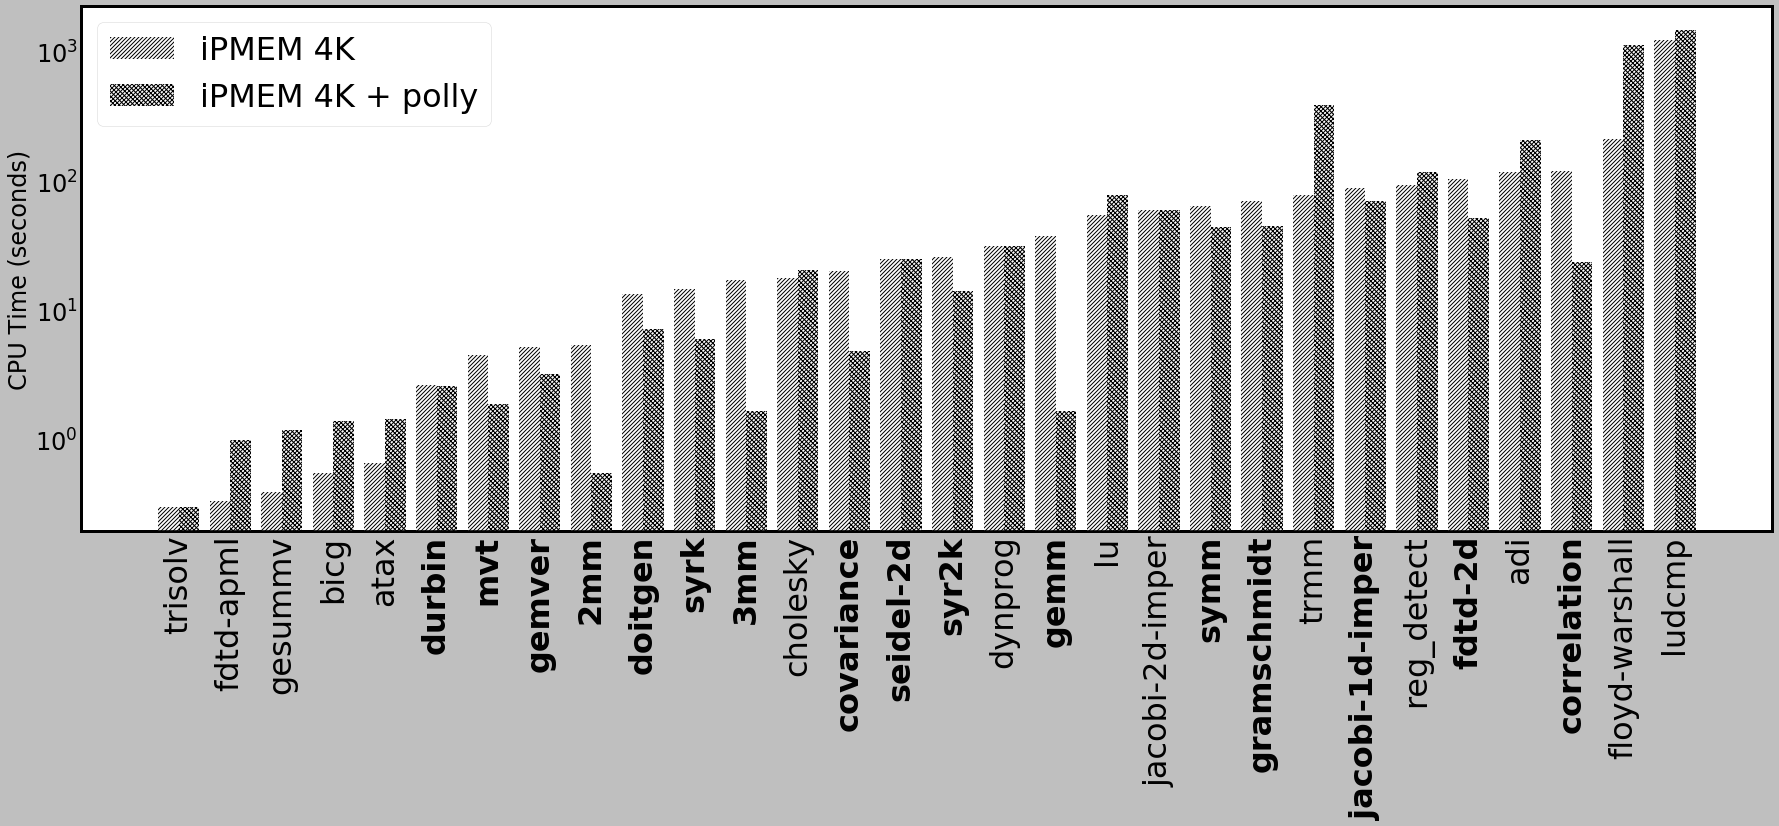

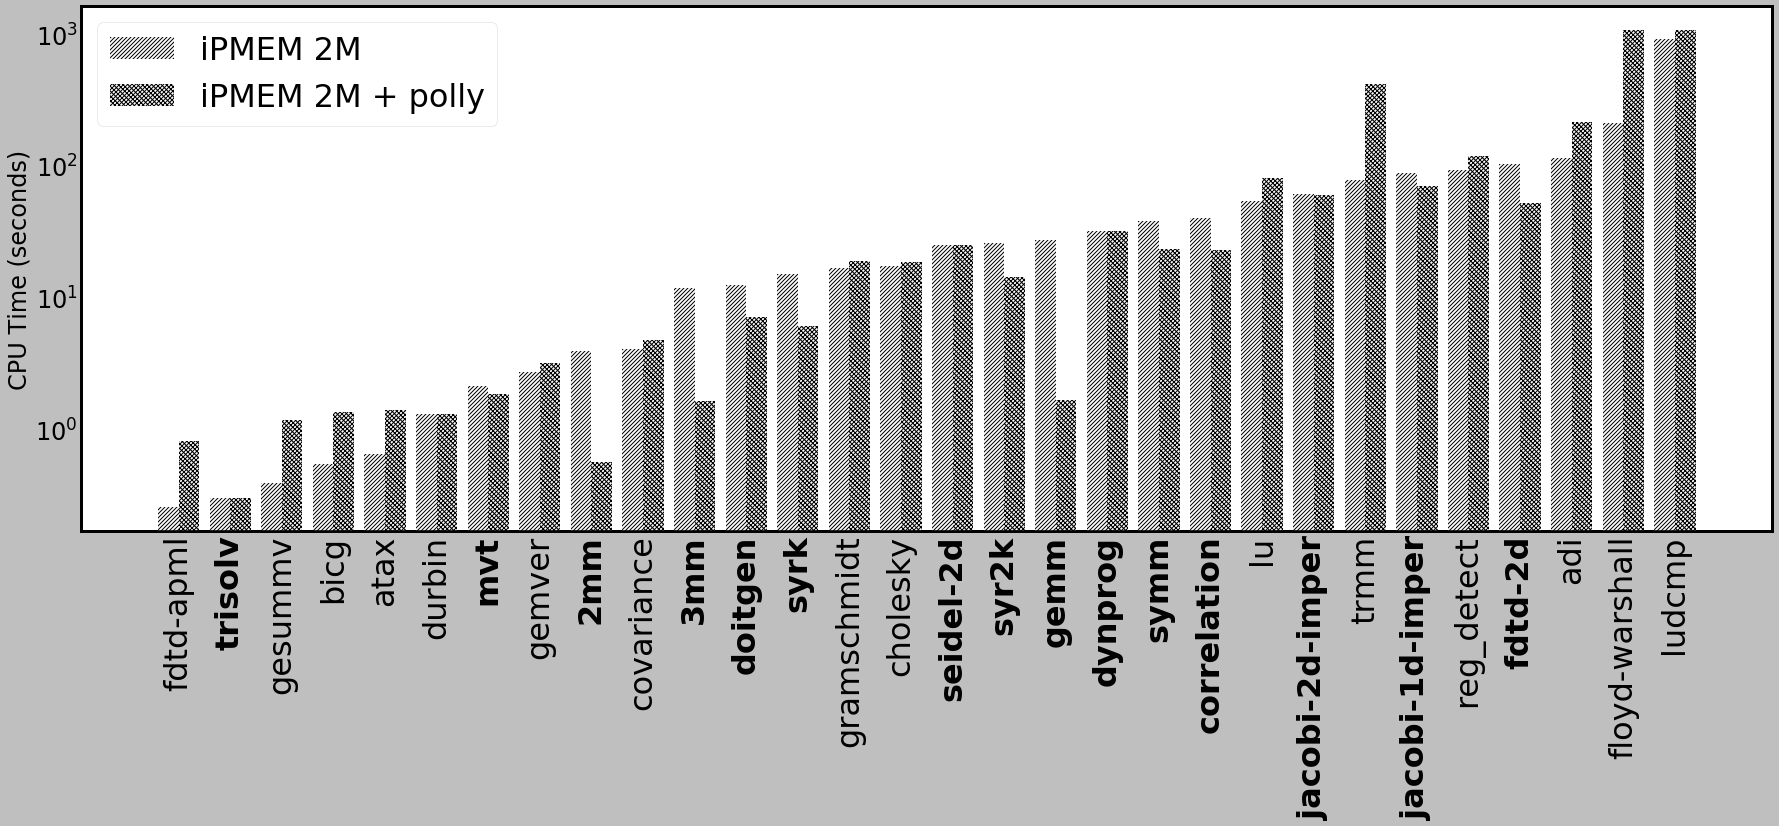

In [273]:
df_sorted = df.sort_values(by=['polybench_time'])

def select_good_tests(df, candidates, memtype, pagesize, epsilon=1.0):
    '''Given a dataframe, a list of candidates, a memory type, and a page size, filter out tests that show at least epsilon improvement'''
    results = []
    for test in candidates:
        base = df.loc[(df['memtype'] == memtype) & (df['test'] == test) & (df['pagesize'] == pagesize) & (df['poly'] == False)]['polybench_time'].values[0]
        poly = df.loc[(df['memtype'] == memtype) & (df['test'] == test) & (df['pagesize'] == pagesize) & (df['poly'] == True)]['polybench_time'].values[0]
        if poly * epsilon < base: results.append(test)
    return results

def poly_plot(data1, data2, tests, highlight, ylabel, label1, label2,tikzfile=None, pngfile=None):
    '''Given two lists of data, plot them'''
    plt.style.use('grayscale')
    n = len(tests)
    assert n == len(data1) and n == len(data2), "Don't expect mismatched data sets"
    fig, ax = plt.subplots(figsize=(27,9))
    index = np.arange(n)
    bar_width = 0.40
    opacity = 0.2
    # http://olsgaard.dk/monochrome-black-white-plots-in-matplotlib.html
    bar_cycle = (cycler('hatch', ['//////', '//////\\\\\\\\\\', '++++++', '||||||','\///', 'xxx', '\\\\']) * cycler('color', 'w')*cycler('zorder', [10]))
    styles = bar_cycle()
    ax.grid(False)
    ax.bar(index, data1, bar_width, alpha=opacity, **next(styles), label=label1)
    ax.bar(index+bar_width, data2, bar_width, alpha=opacity, **next(styles), label=label2)
    #ax.set_xlabel('Polybench Tests (Normalized)', fontsize=24)
    ax.set_ylabel(ylabel, fontsize=24)
    ax.set_xticks(index + 0.5 * bar_width)
    ax.set_xticklabels(tests)
    ax.tick_params(labelsize=16)
    ax.legend(prop=dict(size=32))
    plt.xticks(rotation=90,fontsize=32)
    plt.yticks(fontsize=24)
    for xtl in ax.get_xticklabels():
        if xtl.get_text() in highlight:
            xtl.set_fontweight('bold')
    plt.yscale('log')
    if tikzfile is not None: tikzplotlib.save(tikzfile)
    if pngfile is not None: plt.savefig(pngfile, bbox_inches="tight")
    plt.show()
    
def test_poly_plot(df, memtype='DRAM', pagesize='4K',tikzfile=None, pngfile=None):
    def get_test_data(df, test, memtype, pagesize, poly):
        d1 = df.loc[(df['test'] == test) & (df['memtype'] == memtype) & (df['pagesize'] == pagesize) & (df['poly'] == poly)]['polybench_time'].values[0]
        return d1
    tests = []
    data1 = []
    data2 = []
    highlight = []
    df_sorted = df.sort_values(by=['polybench_time'])
    for test in df_sorted.loc[select(df_sorted, memtype, pagesize, False)].test.unique():
        tests.append(test)
        d1 = get_test_data(df, test, memtype, pagesize, False)
        d2 = get_test_data(df, test, memtype, pagesize, True)
        data1.append(d1)
        data2.append(d2)
        if d2 < d1: highlight.append(test)
    poly_plot(data1, data2, tests, highlight, 
              'CPU Time (seconds)', '{} {}'.format(memtype, pagesize),'{} {} + polly'.format(memtype, pagesize),
              tikzfile=tikzfile, pngfile=pngfile)

print(df.columns)
test_poly_plot(df, 'iPMEM', '4K',pngfile='pb-4K-iPMEM-poly-4K-iPMEM.png')
test_poly_plot(df, 'iPMEM', '2M',pngfile='pb-2M-iPMEM-poly-2M-iPMEM.png')

#pmem_dual_plot2(df_sorted.loc[select(df_sorted, 'PMEM', '2M', True)], 
#               df_sorted.loc[select(df_sorted, 'PMEM', '2M', False)],
#              "PMEM (2M) + Polly", "PMEM (2M)",field='polybench_time', ylabel='CPU Time (seconds)',
#               highlight_tests=select_good_tests(df_sorted, df_sorted.test.unique(), 'PMEM', '2M'))
#pmem_dual_plot2(df_sorted.loc[select(df_sorted, 'PMEM', '4K', True)], 
#               df_sorted.loc[select(df_sorted, 'PMEM', '4K', False)],
#              "PMEM (4K) + Polly", "PMEM (4K)",field='polybench_time', ylabel='CPU Time (seconds)',
#               highlight_tests=select_good_tests(df_sorted, df_sorted.test.unique(), 'PMEM', '4K'))
#pmem_dual_plot2(df_sorted.loc[select(df_sorted, 'iPMEM', '2M', True)], 
#               df_sorted.loc[select(df_sorted, 'iPMEM', '2M', False)],
#              "iPMEM (2M) + Polly", "iPMEM (2M)",field='polybench_time', ylabel='CPU Time (seconds)',
#               highlight_tests=select_good_tests(df_sorted, df_sorted.test.unique(), 'iPMEM', '2M'))
#pmem_dual_plot2(df_sorted.loc[select(df_sorted, 'iPMEM', '4K', True)], 
#               df_sorted.loc[select(df_sorted, 'iPMEM', '4K', False)],
#              "iPMEM (4K) + Polly", "iPMEM (4K)",field='polybench_time', ylabel='CPU Time (seconds)',
#               highlight_tests=select_good_tests(df_sorted, df_sorted.test.unique(), 'iPMEM', '4K'))
#pmem_dual_plot2(df_sorted.loc[select(df_sorted, 'DRAM', '2M', True)], 
#               df_sorted.loc[select(df_sorted, 'DRAM', '2M', False)],
#              "DRAM (2M) + Polly", "DRAM (2M)",field='polybench_time', ylabel='CPU Time (seconds)')
#pmem_dual_plot2(df_sorted.loc[select(df_sorted, 'DRAM', '4K', True)], 
#               df_sorted.loc[select(df_sorted, 'DRAM', '4K', False)],
#              "DRAM (4K) + Polly", "DRAM (4K)",field='polybench_time', ylabel='CPU Time (seconds)')

In [253]:
def test_poly_plot2(df, memtype='iPMEM', pagesize='4K'):
    def get_test_data(df, test, memtype, pagesize, poly):
        d1 = df.loc[(df['test'] == test) & (df['memtype'] == memtype) & (df['pagesize'] == pagesize) & (df['poly'] == poly)]['polybench_time'].values[0]
        return d1
    tests = []
    data1 = []
    data2 = []
    highlight = []
    df_sorted = df.sort_values(by=['polybench_time'])
    for test in df_sorted.loc[select(df_sorted, memtype, pagesize, False)].test.unique():
        tests.append(test)
        d1 = get_test_data(df, test, memtype, pagesize, False)
        d2 = get_test_data(df, test, memtype, pagesize, True)
        data1.append(d1)
        data2.append(d2)
        if d2 < d1: highlight.append(test)
    poly_plot(data1, data2, tests, highlight, 
              'CPU Time (seconds)', '{} {}'.format(memtype, pagesize),'{} {} + polly'.format(memtype, pagesize))


run memtype pagesize             test   poly  \
0   2019_12_28__10_26_54.log    DRAM       2M              2mm  False   
1   2019_12_28__10_26_54.log    DRAM       2M              2mm   True   
2   2019_12_28__10_26_54.log    DRAM       2M              3mm  False   
3   2019_12_28__10_26_54.log    DRAM       2M              3mm   True   
4   2019_12_28__10_26_54.log    DRAM       2M             atax  False   
5   2019_12_28__10_26_54.log    DRAM       2M             atax   True   
6   2019_12_28__10_26_54.log    DRAM       2M             bicg  False   
7   2019_12_28__10_26_54.log    DRAM       2M             bicg   True   
8   2019_12_28__10_26_54.log    DRAM       2M         cholesky  False   
9   2019_12_28__10_26_54.log    DRAM       2M         cholesky   True   
10  2019_12_28__10_26_54.log    DRAM       2M          doitgen  False   
11  2019_12_28__10_26_54.log    DRAM       2M          doitgen   True   
12  2019_12_28__10_26_54.log    DRAM       2M             gemm  False   
13  2019_12_28__10_26_54.log    DRAM       2M             gemm   True   
14  2019_12_28__10_26_54.log    DRAM       2M           gemver  False   
15  2019_12_28__10_26_54.log    DRAM       2M           gemver   True   
16  2019_12_28__10_26_54.log    DRAM       2M          gesummv  False   
17  2019_12_28__10_26_54.log    DRAM       2M          gesummv   True   
18  2019_12_28__10_26_54.log    DRAM       2M              mvt  False   
19  2019_12_28__10_26_54.log    DRAM       2M              mvt   True   
20  2019_12_28__10_26_54.log    DRAM       2M             symm  False   
21  2019_12_28__10_26_54.log    DRAM       2M             symm   True   
22  2019_12_28__10_26_54.log    DRAM       2M            syr2k  False   
23  2019_12_28__10_26_54.log    DRAM       2M            syr2k   True   
24  2019_12_28__10_26_54.log    DRAM       2M             syrk  False   
25  2019_12_28__10_26_54.log    DRAM       2M             syrk   True   
26  2019_12_28__10_26_54.log    DRAM       2M          trisolv  False   
27  2019_12_28__10_26_54.log    DRAM       2M          trisolv   True   
28  2019_12_28__10_26_54.log    DRAM       2M             trmm  False   
29  2019_12_28__10_26_54.log    DRAM       2M             trmm   True   
..                       ...     ...      ...              ...    ...   
30  2019_12_28__18_05_52.log   iPMEM       4K           durbin  False   
31  2019_12_28__18_05_52.log   iPMEM       4K           durbin   True   
32  2019_12_28__18_05_52.log   iPMEM       4K          dynprog  False   
33  2019_12_28__18_05_52.log   iPMEM       4K          dynprog   True   
34  2019_12_28__18_05_52.log   iPMEM       4K      gramschmidt  False   
35  2019_12_28__18_05_52.log   iPMEM       4K      gramschmidt   True   
36  2019_12_28__18_05_52.log   iPMEM       4K               lu  False   
37  2019_12_28__18_05_52.log   iPMEM       4K               lu   True   
38  2019_12_28__18_05_52.log   iPMEM       4K           ludcmp  False   
39  2019_12_28__18_05_52.log   iPMEM       4K           ludcmp   True   
40  2019_12_28__18_05_52.log   iPMEM       4K      correlation  False   
41  2019_12_28__18_05_52.log   iPMEM       4K      correlation   True   
42  2019_12_28__18_05_52.log   iPMEM       4K       covariance  False   
43  2019_12_28__18_05_52.log   iPMEM       4K       covariance   True   
44  2019_12_28__18_05_52.log   iPMEM       4K   floyd-warshall  False   
45  2019_12_28__18_05_52.log   iPMEM       4K   floyd-warshall   True   
46  2019_12_28__18_05_52.log   iPMEM       4K       reg_detect  False   
47  2019_12_28__18_05_52.log   iPMEM       4K       reg_detect   True   
48  2019_12_28__18_05_52.log   iPMEM       4K              adi  False   
49  2019_12_28__18_05_52.log   iPMEM       4K              adi   True   
50  2019_12_28__18_05_52.log   iPMEM       4K          fdtd-2d  False   
51  2019_12_28__18_05_52.log   iPMEM       4K          fdtd-2d   True   
52  2019_12_28__18_05_52.log   iPMEM       4K        fdtd-apml  False   
53  2019_1

In [120]:
# compute normalized time relative to 4K, without polyhedral optimization
def normalize(df, test, memtype, pagesize, poly, base_time):
    location = ((df['test'] == test) &
                (df['memtype'] == memtype) &
                (df['pagesize'] == pagesize) & 
                (df['poly'] == poly))
    #pbt = df.loc[(df['test'] == test) &
    #            (df['memtype'] == memtype) &
    #            (df['pagesize'] == pagesize) & 
    #            (df['poly'] == poly)]['polybench-time'].values[0]
    #df.loc[location]['polybench-time'].values[0]
    #print(df.loc[location]['polybench-time'].values[0])
    df.at[location, 'normalized'] = df.loc[location]['polybench_time'].values[0] / base_time

df = df.assign(normalized=0.0)


for test in df.test.unique():
    bt = df.loc[(df['memtype'] == 'DRAM') & 
                (df['test'] == test) & 
                (df['pagesize'] == '4K') & 
                (df['poly'] == False)]['polybench_time'].values[0]
    bt_poly = df.loc[(df['memtype'] == 'DRAM') & 
                     (df['test'] == test) & 
                     (df['pagesize'] == '4K') & 
                     (df['poly'] == True)]['polybench_time'].values[0]
    for mt in df.memtype.unique():
        for ps in df.pagesize.unique():
            normalize(df, test, mt, ps, False, bt)
            normalize(df, test, mt, ps, True, bt_poly)
df

run memtype pagesize             test   poly  \
0   2019_12_28__10_26_54.log    DRAM       2M              2mm  False   
1   2019_12_28__10_26_54.log    DRAM       2M              2mm   True   
2   2019_12_28__10_26_54.log    DRAM       2M              3mm  False   
3   2019_12_28__10_26_54.log    DRAM       2M              3mm   True   
4   2019_12_28__10_26_54.log    DRAM       2M             atax  False   
5   2019_12_28__10_26_54.log    DRAM       2M             atax   True   
6   2019_12_28__10_26_54.log    DRAM       2M             bicg  False   
7   2019_12_28__10_26_54.log    DRAM       2M             bicg   True   
8   2019_12_28__10_26_54.log    DRAM       2M         cholesky  False   
9   2019_12_28__10_26_54.log    DRAM       2M         cholesky   True   
10  2019_12_28__10_26_54.log    DRAM       2M          doitgen  False   
11  2019_12_28__10_26_54.log    DRAM       2M          doitgen   True   
12  2019_12_28__10_26_54.log    DRAM       2M             gemm  False   
13  2019_12_28__10_26_54.log    DRAM       2M             gemm   True   
14  2019_12_28__10_26_54.log    DRAM       2M           gemver  False   
15  2019_12_28__10_26_54.log    DRAM       2M           gemver   True   
16  2019_12_28__10_26_54.log    DRAM       2M          gesummv  False   
17  2019_12_28__10_26_54.log    DRAM       2M          gesummv   True   
18  2019_12_28__10_26_54.log    DRAM       2M              mvt  False   
19  2019_12_28__10_26_54.log    DRAM       2M              mvt   True   
20  2019_12_28__10_26_54.log    DRAM       2M             symm  False   
21  2019_12_28__10_26_54.log    DRAM       2M             symm   True   
22  2019_12_28__10_26_54.log    DRAM       2M            syr2k  False   
23  2019_12_28__10_26_54.log    DRAM       2M            syr2k   True   
24  2019_12_28__10_26_54.log    DRAM       2M             syrk  False   
25  2019_12_28__10_26_54.log    DRAM       2M             syrk   True   
26  2019_12_28__10_26_54.log    DRAM       2M          trisolv  False   
27  2019_12_28__10_26_54.log    DRAM       2M          trisolv   True   
28  2019_12_28__10_26_54.log    DRAM       2M             trmm  False   
29  2019_12_28__10_26_54.log    DRAM       2M             trmm   True   
..                       ...     ...      ...              ...    ...   
30  2019_12_28__18_05_52.log   iPMEM       4K           durbin  False   
31  2019_12_28__18_05_52.log   iPMEM       4K           durbin   True   
32  2019_12_28__18_05_52.log   iPMEM       4K          dynprog  False   
33  2019_12_28__18_05_52.log   iPMEM       4K          dynprog   True   
34  2019_12_28__18_05_52.log   iPMEM       4K      gramschmidt  False   
35  2019_12_28__18_05_52.log   iPMEM       4K      gramschmidt   True   
36  2019_12_28__18_05_52.log   iPMEM       4K               lu  False   
37  2019_12_28__18_05_52.log   iPMEM       4K               lu   True   
38  2019_12_28__18_05_52.log   iPMEM       4K           ludcmp  False   
39  2019_12_28__18_05_52.log   iPMEM       4K           ludcmp   True   
40  2019_12_28__18_05_52.log   iPMEM       4K      correlation  False   
41  2019_12_28__18_05_52.log   iPMEM       4K      correlation   True   
42  2019_12_28__18_05_52.log   iPMEM       4K       covariance  False   
43  2019_12_28__18_05_52.log   iPMEM       4K       covariance   True   
44  2019_12_28__18_05_52.log   iPMEM       4K   floyd-warshall  False   
45  2019_12_28__18_05_52.log   iPMEM       4K   floyd-warshall   True   
46  2019_12_28__18_05_52.log   iPMEM       4K       reg_detect  False   
47  2019_12_28__18_05_52.log   iPMEM       4K       reg_detect   True   
48  2019_12_28__18_05_52.log   iPMEM       4K              adi  False   
49  2019_12_28__18_05_52.log   iPMEM       4K              adi   True   
50  2019_12_28__18_05_52.log   iPMEM       4K          fdtd-2d  False   
51  2019_12_28__18_05_52.log   iPMEM       4K          fdtd-2d   True   
52  2019_12_28__18_05_52.log   iPMEM       4K        fdtd-apml  False   
53  2019_1

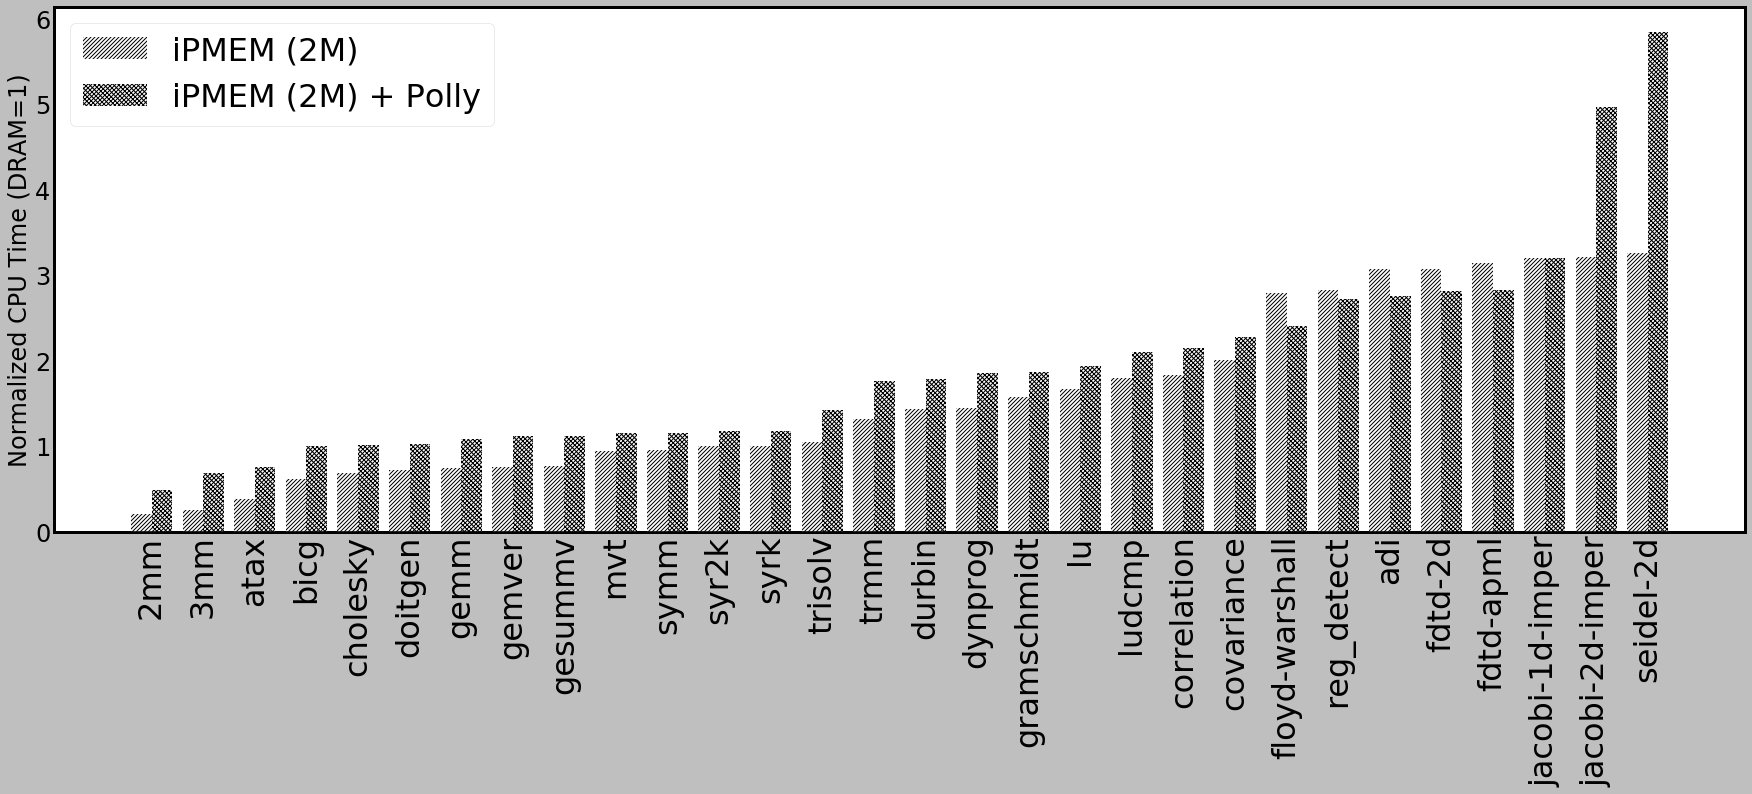

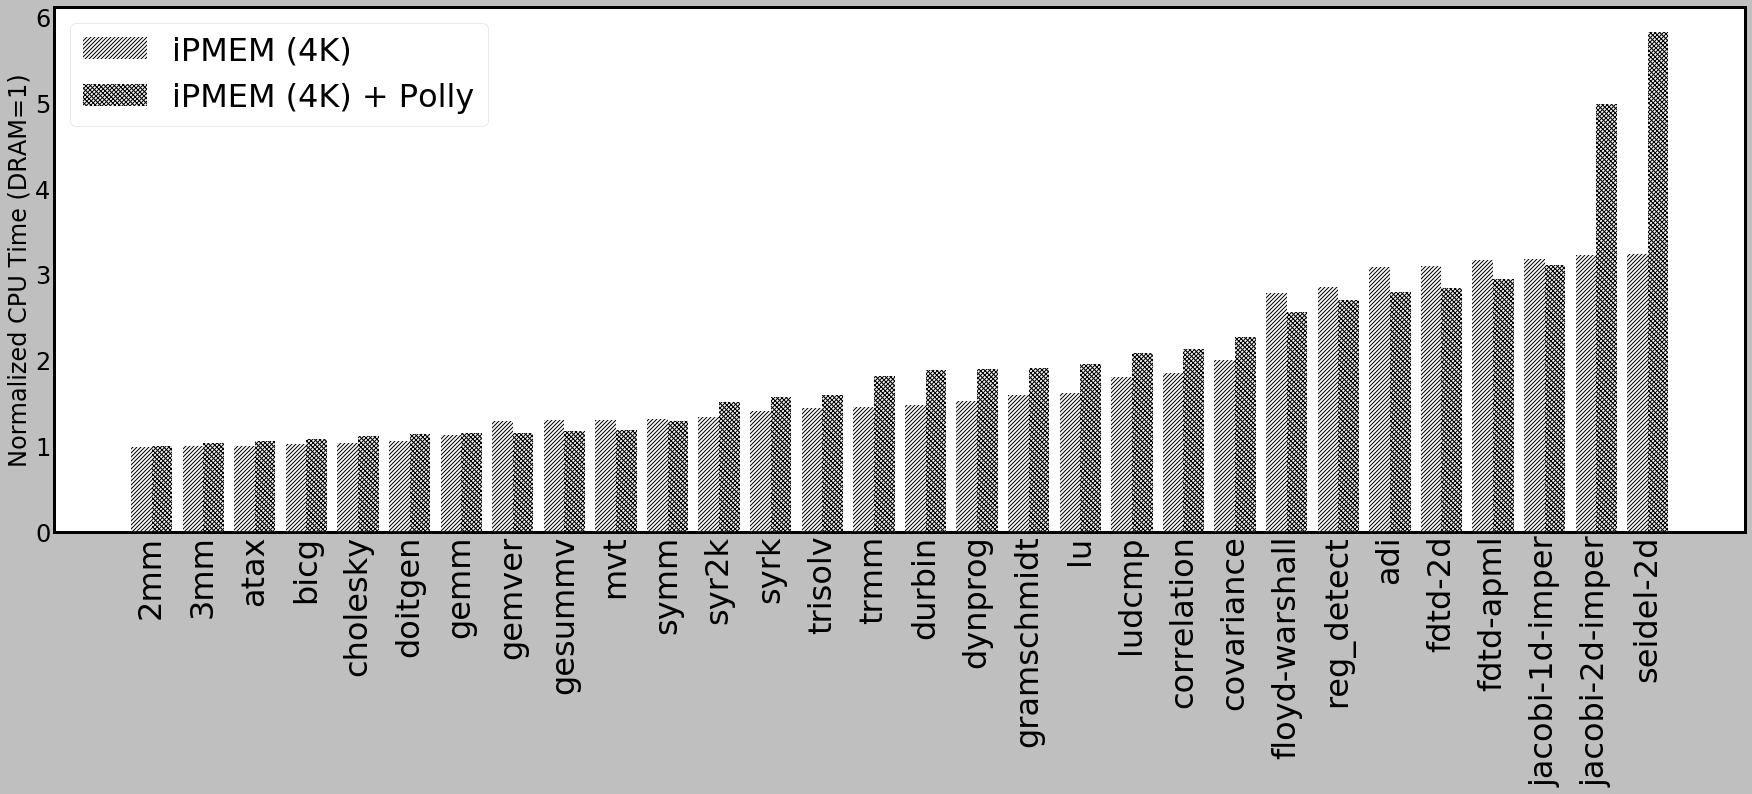

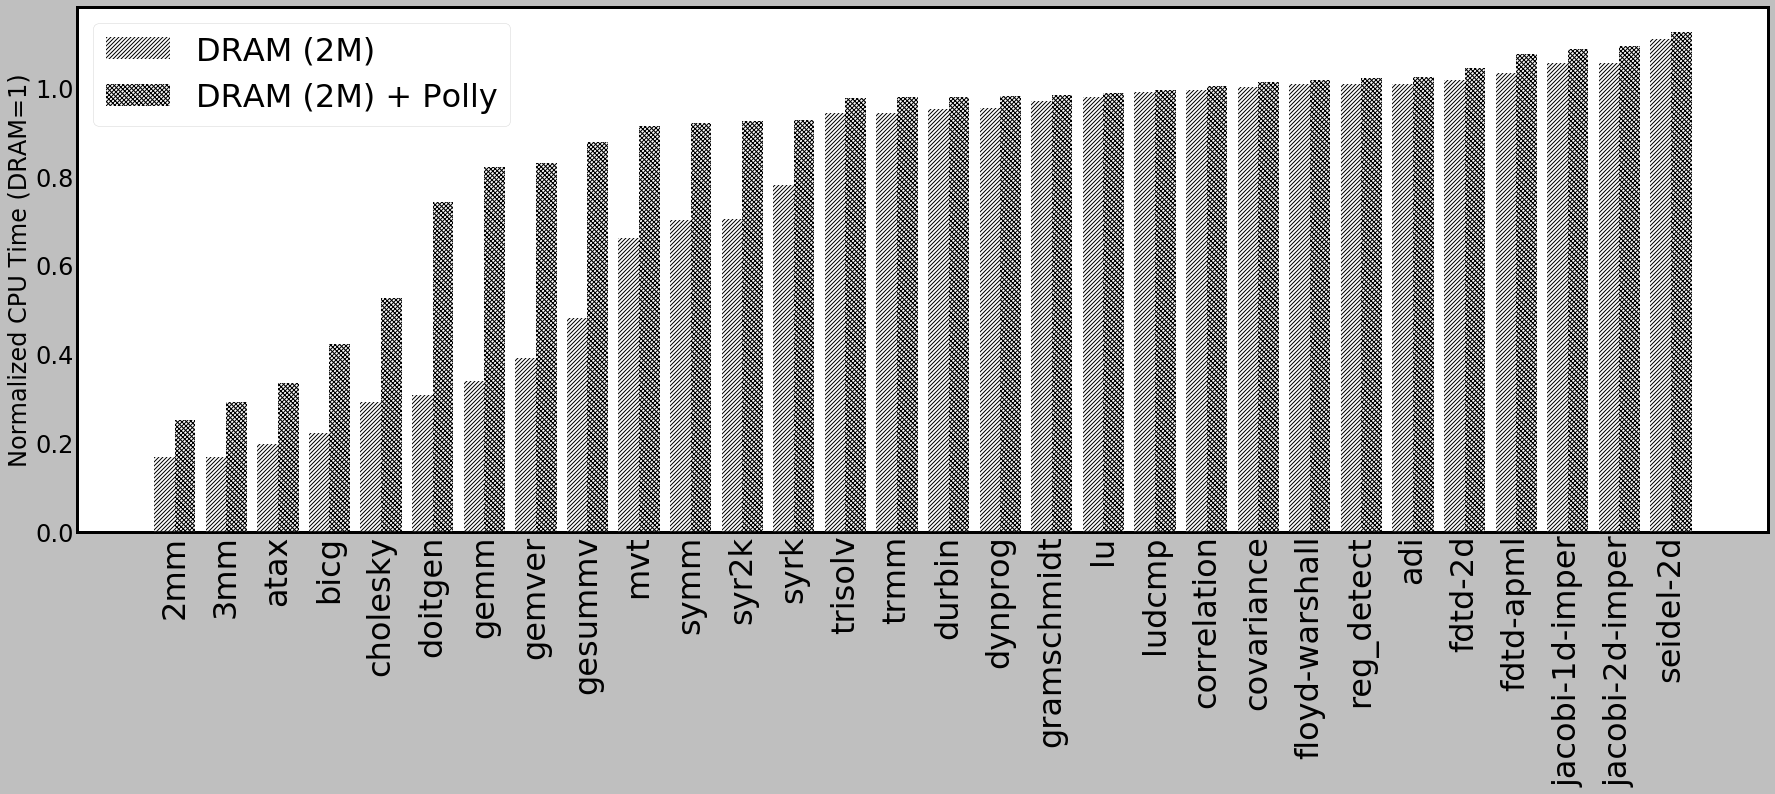

In [121]:
df_sorted = df.sort_values(by=['normalized'])

pmem_dual_plot(df_sorted.loc[select(df_sorted, 'iPMEM', '2M', True)], 
               df_sorted.loc[select(df_sorted, 'iPMEM', '2M', False)],
              "iPMEM (2M) + Polly", "iPMEM (2M)")
pmem_dual_plot(df_sorted.loc[select(df_sorted, 'iPMEM', '4K', True)], 

               df_sorted.loc[select(df_sorted, 'iPMEM', '4K', False)],
              "iPMEM (4K) + Polly", "iPMEM (4K)")
# 4K DRAM doesn't work, since it is normalized against 4K
pmem_dual_plot(df_sorted.loc[select(df_sorted, 'DRAM', '2M', True)], 
               df_sorted.loc[select(df_sorted, 'DRAM', '2M', False)],
              "DRAM (2M) + Polly", "DRAM (2M)")

In [169]:
df = df.drop('normalized',axis=1)
df = df.assign(normalized=0.0)

# compute normalized time relative to 4K, without polyhedral optimization
def normalize(df, test, memtype, pagesize, poly, base_time):
    location = ((df['test'] == test) &
                (df['memtype'] == memtype) &
                (df['pagesize'] == pagesize) & 
                (df['poly'] == poly))
    #pbt = df.loc[(df['test'] == test) &
    #            (df['memtype'] == memtype) &
    #            (df['pagesize'] == pagesize) & 
    #            (df['poly'] == poly)]['polybench-time'].values[0]
    #df.loc[location]['polybench-time'].values[0]
    #print(df.loc[location]['polybench-time'].values[0])
    df.at[location, 'normalized'] = df.loc[location]['polybench_time'].values[0] / base_time

df = df.assign(normalized=0.0)

for test in df.test.unique():
    bt = df.loc[(df['memtype'] == 'DRAM') & 
                (df['test'] == test) & 
                (df['pagesize'] == '4K') & 
                (df['poly'] == False)]['polybench_time'].values[0]
    bt_poly = df.loc[(df['memtype'] == 'DRAM') & 
                     (df['test'] == test) & 
                     (df['pagesize'] == '4K') & 
                     (df['poly'] == True)]['polybench_time'].values[0]
    for mt in df.memtype.unique():
        for ps in df.pagesize.unique():
            normalize(df, test, mt, ps, False, bt)
            normalize(df, test, mt, ps, True, bt_poly)
df



run memtype pagesize             test   poly  \
0   2019_12_28__10_26_54.log    DRAM       2M              2mm  False   
1   2019_12_28__10_26_54.log    DRAM       2M              2mm   True   
2   2019_12_28__10_26_54.log    DRAM       2M              3mm  False   
3   2019_12_28__10_26_54.log    DRAM       2M              3mm   True   
4   2019_12_28__10_26_54.log    DRAM       2M             atax  False   
5   2019_12_28__10_26_54.log    DRAM       2M             atax   True   
6   2019_12_28__10_26_54.log    DRAM       2M             bicg  False   
7   2019_12_28__10_26_54.log    DRAM       2M             bicg   True   
8   2019_12_28__10_26_54.log    DRAM       2M         cholesky  False   
9   2019_12_28__10_26_54.log    DRAM       2M         cholesky   True   
10  2019_12_28__10_26_54.log    DRAM       2M          doitgen  False   
11  2019_12_28__10_26_54.log    DRAM       2M          doitgen   True   
12  2019_12_28__10_26_54.log    DRAM       2M             gemm  False   
13  2019_12_28__10_26_54.log    DRAM       2M             gemm   True   
14  2019_12_28__10_26_54.log    DRAM       2M           gemver  False   
15  2019_12_28__10_26_54.log    DRAM       2M           gemver   True   
16  2019_12_28__10_26_54.log    DRAM       2M          gesummv  False   
17  2019_12_28__10_26_54.log    DRAM       2M          gesummv   True   
18  2019_12_28__10_26_54.log    DRAM       2M              mvt  False   
19  2019_12_28__10_26_54.log    DRAM       2M              mvt   True   
20  2019_12_28__10_26_54.log    DRAM       2M             symm  False   
21  2019_12_28__10_26_54.log    DRAM       2M             symm   True   
22  2019_12_28__10_26_54.log    DRAM       2M            syr2k  False   
23  2019_12_28__10_26_54.log    DRAM       2M            syr2k   True   
24  2019_12_28__10_26_54.log    DRAM       2M             syrk  False   
25  2019_12_28__10_26_54.log    DRAM       2M             syrk   True   
26  2019_12_28__10_26_54.log    DRAM       2M          trisolv  False   
27  2019_12_28__10_26_54.log    DRAM       2M          trisolv   True   
28  2019_12_28__10_26_54.log    DRAM       2M             trmm  False   
29  2019_12_28__10_26_54.log    DRAM       2M             trmm   True   
..                       ...     ...      ...              ...    ...   
30  2019_12_28__18_05_52.log   iPMEM       4K           durbin  False   
31  2019_12_28__18_05_52.log   iPMEM       4K           durbin   True   
32  2019_12_28__18_05_52.log   iPMEM       4K          dynprog  False   
33  2019_12_28__18_05_52.log   iPMEM       4K          dynprog   True   
34  2019_12_28__18_05_52.log   iPMEM       4K      gramschmidt  False   
35  2019_12_28__18_05_52.log   iPMEM       4K      gramschmidt   True   
36  2019_12_28__18_05_52.log   iPMEM       4K               lu  False   
37  2019_12_28__18_05_52.log   iPMEM       4K               lu   True   
38  2019_12_28__18_05_52.log   iPMEM       4K           ludcmp  False   
39  2019_12_28__18_05_52.log   iPMEM       4K           ludcmp   True   
40  2019_12_28__18_05_52.log   iPMEM       4K      correlation  False   
41  2019_12_28__18_05_52.log   iPMEM       4K      correlation   True   
42  2019_12_28__18_05_52.log   iPMEM       4K       covariance  False   
43  2019_12_28__18_05_52.log   iPMEM       4K       covariance   True   
44  2019_12_28__18_05_52.log   iPMEM       4K   floyd-warshall  False   
45  2019_12_28__18_05_52.log   iPMEM       4K   floyd-warshall   True   
46  2019_12_28__18_05_52.log   iPMEM       4K       reg_detect  False   
47  2019_12_28__18_05_52.log   iPMEM       4K       reg_detect   True   
48  2019_12_28__18_05_52.log   iPMEM       4K              adi  False   
49  2019_12_28__18_05_52.log   iPMEM       4K              adi   True   
50  2019_12_28__18_05_52.log   iPMEM       4K          fdtd-2d  False   
51  2019_12_28__18_05_52.log   iPMEM       4K          fdtd-2d   True   
52  2019_12_28__18_05_52.log   iPMEM       4K        fdtd-apml  False   
53  2019_1